In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize
from matplotlib import cm
import os
import math
%matplotlib inline

In [2]:
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams.update({'font.size': 20})

In [3]:
def plotHeatmap(x,y,nbin,xlabel='',ylabel='',title='',hold=False):

    [HH,xh,yh] = np.histogram2d(x,y,bins=(nbin,nbin))
    HH = HH.T/(1.)
    xmin,xmax=xh[0],xh[-1]
    ymin,ymax=yh[0],yh[-1]
    plt.imshow(HH,interpolation='nearest',origin='low',extent=[xmin,xmax,ymin,ymax],aspect='auto',cmap='gnuplot2_r')#,cmap='jet',vmin=0.,vmax=100,aspect='auto')
    plt.colorbar(label="Number of Initial Conditions")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)    
    plt.title(title)   
    if not hold:
        plt.show()
    plt.close()
    return [HH,xh,yh]

In [4]:
def stateThresholds():
    ''''''
    return {'Zeb mRNA':[ 62+(301-62)/2.,301+(990-301)/2.]
            ,'$\mu_{200}$':[1265+(12389-1265)/2.,12389+(19098-12389)/2.],
            'Hif-1':[26+(292-26)/2.,292+(490-292)/2.],
            'AMPK':[69+(327-69)/2.,327+(436-327)/2.]}

In [5]:
def getStates_fromMap(df_res,hold=False):

    x2 = df_res['A']
    y2 = df_res['h']
    x1 = df_res['u']
    y1 = df_res['mz']
    hm1= plotHeatmap(x1,y1,10,'$\mu_{200}$','Zeb mRNA','Steady States',hold)
    hm2 =plotHeatmap(x2,y2,10,'AMPK','Hif-1','Steady States',hold)
    res2,res1={'n':[],'u':[],'mz':[]},{'n':[],'A':[],'h':[]}
    
    thresh = stateThresholds()
            
    E = (df_res['u']>thresh['$\mu_{200}$'][1])*(df_res['mz']<=thresh['Zeb mRNA'][0])
    M = (df_res['u']<=thresh['$\mu_{200}$'][0])*(df_res['mz']>thresh['Zeb mRNA'][1])
    EM =(df_res['u']>thresh['$\mu_{200}$'][0])*(df_res['u']<=thresh['$\mu_{200}$'][1])*(df_res['mz']>thresh['Zeb mRNA'][0])*(df_res['mz']<=thresh['Zeb mRNA'][1])
    
    
    O = (df_res['A']>thresh['AMPK'][1])*(df_res['h']<=thresh['Hif-1'][0])
    W = (df_res['A']<=thresh['AMPK'][0])*(df_res['h']>thresh['Hif-1'][1])
    WO =(df_res['A']>thresh['AMPK'][0])*(df_res['A']<=thresh['AMPK'][1])*(df_res['h']>thresh['Hif-1'][0])*(df_res['h']<=thresh['Hif-1'][1])
    
    
    #print E,M,EM,E+EM+M,np.sum(df_res['u']>=-11)
    #print O,W,WO,O+W+WO
    
    tmp = np.sum(E)+np.sum(EM)+np.sum(M)+np.sum(O)+np.sum(WO)+np.sum(W)
    resultsS = {'name':['E','EM','M','O','WO','W','unknown'],
                'amount':[np.sum(E),np.sum(EM),np.sum(M),np.sum(O),np.sum(WO),np.sum(W),len(df_res['Z'])-tmp]}
    
    tmp = np.sum(E*O)+np.sum(E*WO)+np.sum(E*W)+np.sum(EM*O)+np.sum(EM*WO)+np.sum(EM*W)+np.sum(M*O)+np.sum(M*WO)+np.sum(M*W)
    resultsE = {}
    resultsE = {'name':['E/O','E/WO','E/W','EM/O','EM/WO','EM/W','M/O','M/WO','M/W','unknown'],
                'amount':[np.sum(E*O),np.sum(E*WO),np.sum(E*W),np.sum(EM*O),np.sum(EM*WO),np.sum(EM*W),np.sum(M*O),np.sum(M*WO),np.sum(M*W),len(df_res['Z'])-tmp]}
    maxV = np.max(resultsE['amount'])
    #print np.sum(resultsE['amount']),len(df_res['Z'])
    return resultsE,resultsS,maxV

In [6]:
def plotRes(filename):
    df_res = pd.read_csv(filename).dropna()  
    mapResE,mapResS,maxC =getStates_fromMap(df_res)
    
    my_cmap = mpl.cm.get_cmap('rainbow')#gist_ncar')
    my_norm = Normalize(vmin=0, vmax=maxC)

    fig = plt.figure()
    xvals = np.arange(0,len(mapResE['amount']))
    plt.bar(xvals,mapResE['amount'],color=my_cmap(my_norm(mapResE['amount'])))
    plt.xticks(xvals,mapResE['name'],rotation=80)
    plt.yscale("log")
    plt.xlabel("Steady state")
    plt.ylabel("Number of Initial Conditions")
    title = filename.replace("res","emt")
    title = title.replace("txt","png")
    print title
    #fig.savefig(title,bbox_inches='tight')
    plt.show()
    plt.close()

    '''
    fig = plt.figure()
    xvals = np.arange(0,len(mapResM['amount']))
    plt.bar(xvals,mapResM['amount'],color=my_cmap(my_norm(mapResM['amount'])))
    plt.xticks(xvals,mapResM['name'],rotation=80)
    plt.yscale("log")
    plt.xlabel("Steady state")
    plt.ylabel("Number of Initial Conditions")
    title = filename.replace("txt","png")
    title = title.replace("res","mr")
    print title
    fig.savefig(title,bbox_inches='tight')
    '''
    plt.show()


In [7]:
def plotCoupled(results,nocross,nics):
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(30,30))
    for name in results:
        ax1.plot(results[name]['E/O'][0],results[name]['E/O'][1],'*-',markersize=20,label=name)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax2.plot(results[name]['E/WO'][0],results[name]['E/WO'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax3.plot(results[name]['E/W'][0],results[name]['E/W'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax4.plot(results[name]['EM/O'][0],results[name]['EM/O'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax5.plot(results[name]['EM/WO'][0],results[name]['EM/WO'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax6.plot(results[name]['EM/W'][0],results[name]['EM/W'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax7.plot(results[name]['M/O'][0],results[name]['M/O'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax8.plot(results[name]['M/WO'][0],results[name]['M/WO'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax9.plot(results[name]['M/W'][0],results[name]['M/W'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        
    ax1.hlines(nocross['amount'][0]/nics*100.,xmin=np.min(results[name]['E/O'][0]),xmax=np.max(results[name]['E/O'][0]),linewidth=4,label='No crosstalk')
    ax2.hlines(nocross['amount'][1]/nics*100.,xmin=np.min(results[name]['E/O'][0]),xmax=np.max(results[name]['E/O'][0]),linewidth=4)
    ax3.hlines(nocross['amount'][2]/nics*100.,xmin=np.min(results[name]['E/O'][0]),xmax=np.max(results[name]['E/O'][0]),linewidth=4)
    ax4.hlines(nocross['amount'][3]/nics*100.,xmin=np.min(results[name]['E/O'][0]),xmax=np.max(results[name]['E/O'][0]),linewidth=4)
    ax5.hlines(nocross['amount'][4]/nics*100.,xmin=np.min(results[name]['E/O'][0]),xmax=np.max(results[name]['E/O'][0]),linewidth=4)
    ax6.hlines(nocross['amount'][5]/nics*100.,xmin=np.min(results[name]['E/O'][0]),xmax=np.max(results[name]['E/O'][0]),linewidth=4)
    ax7.hlines(nocross['amount'][6]/nics*100.,xmin=np.min(results[name]['E/O'][0]),xmax=np.max(results[name]['E/O'][0]),linewidth=4)
    ax8.hlines(nocross['amount'][7]/nics*100.,xmin=np.min(results[name]['E/O'][0]),xmax=np.max(results[name]['E/O'][0]),linewidth=4)
    ax9.hlines(nocross['amount'][8]/nics*100.,xmin=np.min(results[name]['E/O'][0]),xmax=np.max(results[name]['E/O'][0]),linewidth=4)
    ax1.set_xlabel("Foldchange")#"Steady state")
    ax2.set_xlabel("Foldchange")#"Steady state")
    ax3.set_xlabel("Foldchange")#"Steady state")
    ax4.set_xlabel("Foldchange")#"Steady state")
    ax5.set_xlabel("Foldchange")#"Steady state")
    ax6.set_xlabel("Foldchange")#"Steady state")
    ax7.set_xlabel("Foldchange")#"Steady state")
    ax8.set_xlabel("Foldchange")#"Steady state")
    ax9.set_xlabel("Foldchange")#"Steady state")
    ax1.set_ylabel("Percentage IC ")
    ax2.set_ylabel("Percentage IC ")
    ax3.set_ylabel("Percentage IC ")
    ax4.set_ylabel("Percentage IC ")
    ax5.set_ylabel("Percentage IC ")
    ax6.set_ylabel("Percentage IC ")
    ax7.set_ylabel("Percentage IC ")
    ax8.set_ylabel("Percentage IC ")
    ax9.set_ylabel("Percentage IC ")
    ax1.set_title("E/O")
    ax2.set_title("E/WO")
    ax3.set_title("E/W")
    ax4.set_title("EM/O")
    ax5.set_title("EM/WO")
    ax6.set_title("EM/W")
    ax7.set_title("M/O")
    ax8.set_title("M/WO")
    ax9.set_title("M/W")
    ax1.legend()
    plt.show()

In [8]:
def plotStateSum(results,nocross,nics):
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(30,30))
    for name in results:
        ax1.plot(results[name]['E'][0],results[name]['E'][1],'*-',markersize=20,label=name)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax2.plot(results[name]['EM'][0],results[name]['EM'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax3.plot(results[name]['M'][0],results[name]['M'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax4.plot(results[name]['O'][0],results[name]['O'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax5.plot(results[name]['WO'][0],results[name]['WO'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        ax6.plot(results[name]['W'][0],results[name]['W'][1],'*-',markersize=20)#,color=my_cmap(my_norm(mapResE['amount']/nics)))
        
    ax1.hlines(nocross['amount'][0]/nics*100.,xmin=np.min(results[name]['E'][0]),xmax=np.max(results[name]['E'][0]),linewidth=4,label='No crosstalk')
    ax2.hlines(nocross['amount'][1]/nics*100.,xmin=np.min(results[name]['E'][0]),xmax=np.max(results[name]['E'][0]),linewidth=4)
    ax3.hlines(nocross['amount'][2]/nics*100.,xmin=np.min(results[name]['E'][0]),xmax=np.max(results[name]['E'][0]),linewidth=4)
    ax4.hlines(nocross['amount'][3]/nics*100.,xmin=np.min(results[name]['E'][0]),xmax=np.max(results[name]['E'][0]),linewidth=4)
    ax5.hlines(nocross['amount'][4]/nics*100.,xmin=np.min(results[name]['E'][0]),xmax=np.max(results[name]['E'][0]),linewidth=4)
    ax6.hlines(nocross['amount'][5]/nics*100.,xmin=np.min(results[name]['E'][0]),xmax=np.max(results[name]['E'][0]),linewidth=4)
    ax1.set_xlabel("Foldchange")#"Steady state")
    ax2.set_xlabel("Foldchange")#"Steady state")
    ax3.set_xlabel("Foldchange")#"Steady state")
    ax4.set_xlabel("Foldchange")#"Steady state")
    ax5.set_xlabel("Foldchange")#"Steady state")
    ax6.set_xlabel("Foldchange")#"Steady state")
    ax1.set_ylabel("Percentage IC ")
    ax2.set_ylabel("Percentage IC ")
    ax3.set_ylabel("Percentage IC ")
    ax4.set_ylabel("Percentage IC ")
    ax5.set_ylabel("Percentage IC ")
    ax6.set_ylabel("Percentage IC ")
    ax1.set_title("E")
    ax2.set_title("EM")
    ax3.set_title("M")
    ax4.set_title("O")
    ax5.set_title("WO")
    ax6.set_title("W")
    ax1.legend()
    plt.show()

In [9]:
def plotPercAll(regs,ogFile,dirc):
    
    df_res =pd.read_csv()
    nocross,noCs,tmp  =getStates_fromMap(df_res)
    
    results={}
    resultsSum={}
    for name in regs:
        fcL = np.array(regs[name]).astype(float)
        if 0 in fcL:
            fcL = fcL*0.1
    
        tmpL={'E/O':[[],[]],'E/W':[[],[]],'E/WO':[[],[]],'EM/O':[[],[]],'EM/W':[[],[]],'EM/WO':[[],[]],'M/O':[[],[]],'M/W':[[],[]],'M/WO':[[],[]],'unknown':[[],[]]}
        tmpS={'E':[[],[]],'EM':[[],[]],'M':[[],[]],'O':[[],[]],'WO':[[],[]],'W':[[],[]],'unknown':[[],[]]}
        for i in range(len(fcL)):
            nics=1000.
            df = pd.read_csv(dirc+"EMT_MR_"+str(name)+str(regs[name][i])+"_"+str(int(nics))+"_res.txt").dropna()

            mapResE,resSum,maxC =getStates_fromMap(df,hold=True)
            for k in range(len(mapResE['name'])):
                tmp = mapResE['name'][k]
                tmpL[tmp][0]+=[fcL[i]] 
                tmpL[tmp][1]+=[mapResE['amount'][k]/nics*100.]
                
            for k in range(len(resSum['name'])):
                tmp = resSum['name'][k]
                tmpS[tmp][0]+=[fcL[i]]
                tmpS[tmp][1]+=[resSum['amount'][k]/nics*100.]

        for key in tmpL:
            ind = np.argsort(tmpL[key][0])
            tmpL[key][0] = np.array(tmpL[key][0])[ind]
            tmpL[key][1] = np.array(tmpL[key][1])[ind]
            
        for key in tmpS:
            ind = np.argsort(tmpS[key][0])
            tmpS[key][0]= np.array(tmpS[key][0])[ind]
            tmpS[key][1]= np.array(tmpS[key][1])[ind]
            
        results[name]=tmpL
        resultsSum[name]=tmpS
            
    plotCoupled(results,nocross,nics)
    plotStateSum(resultsSum,noCs,nics)
    

    #plt.close()


In [10]:
def plotFCSingleLink():
    
    ogFile="coupledWReg_Ccode/crosstalk_comparison/EMT_MR_comp_0_1000_res.txt"
    dirc="coupledWReg_Ccode/crosstalk_singles/"
    nics=1000.
    direct = "coupledWReg_Ccode/crosstalk_singles/"
    regsA={}
    for filen in os.listdir(direct):
        if "res.txt" in filen:
            #plotRes(direct+filen)
            name= filen.split(".")[0].split("_")[2]
            lamda=''
            while name[-1].isdigit():
                lamda+=name[-1]
                name = name[:-1]

            if name not in regsA.keys():
                regsA[name]=[]
            regsA[name]+=[[lamda,filen]]
    
    df_res =pd.read_csv(ogFile).dropna()
    nocross,noCs,tmp  =getStates_fromMap(df_res,hold=True)
    for name in regsA:
        print name
        regs = regsA[name]
        results={}
        resultsSum={}
        fcL = np.array(regs)[:,0].astype(float)
        if 0 in fcL:
            fcL = fcL*0.1

        tmpL={'E/O':[[],[]],'E/W':[[],[]],'E/WO':[[],[]],'EM/O':[[],[]],'EM/W':[[],[]],'EM/WO':[[],[]],'M/O':[[],[]],'M/W':[[],[]],'M/WO':[[],[]],'unknown':[[],[]]}
        tmpS={'E':[[],[]],'EM':[[],[]],'M':[[],[]],'O':[[],[]],'WO':[[],[]],'W':[[],[]],'unknown':[[],[]]}
        for i in range(len(fcL)):
                df = pd.read_csv(dirc+regs[i][1]).dropna()

                try:
                    mapResE,resSum,maxC =getStates_fromMap(df,hold=True)
                    for k in range(len(mapResE['name'])):
                        tmp = mapResE['name'][k]
                        tmpL[tmp][0]+=[fcL[i]] 
                        tmpL[tmp][1]+=[mapResE['amount'][k]/nics*100.]

                    for k in range(len(resSum['name'])):
                        tmp = resSum['name'][k]
                        tmpS[tmp][0]+=[fcL[i]]
                        tmpS[tmp][1]+=[resSum['amount'][k]/nics*100.]
                except:
                    print "error with" , dirc+regs[i][1]
        for key in tmpL:
                ind = np.argsort(tmpL[key][0])
                tmpL[key][0] = np.array(tmpL[key][0])[ind]
                tmpL[key][1] = np.array(tmpL[key][1])[ind]

        for key in tmpS:
                ind = np.argsort(tmpS[key][0])
                tmpS[key][0]= np.array(tmpS[key][0])[ind]
                tmpS[key][1]= np.array(tmpS[key][1])[ind]

        results[name]=tmpL
        resultsSum[name]=tmpS

        mpl.rcParams['xtick.labelsize'] = 30
        mpl.rcParams['ytick.labelsize'] = 30
        mpl.rcParams.update({'font.size': 30})

        plotCoupled(results,nocross,nics)
        plotStateSum(resultsSum,noCs,nics)

        plt.show()

/home/madeline/anaconda2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


lamdaAZ


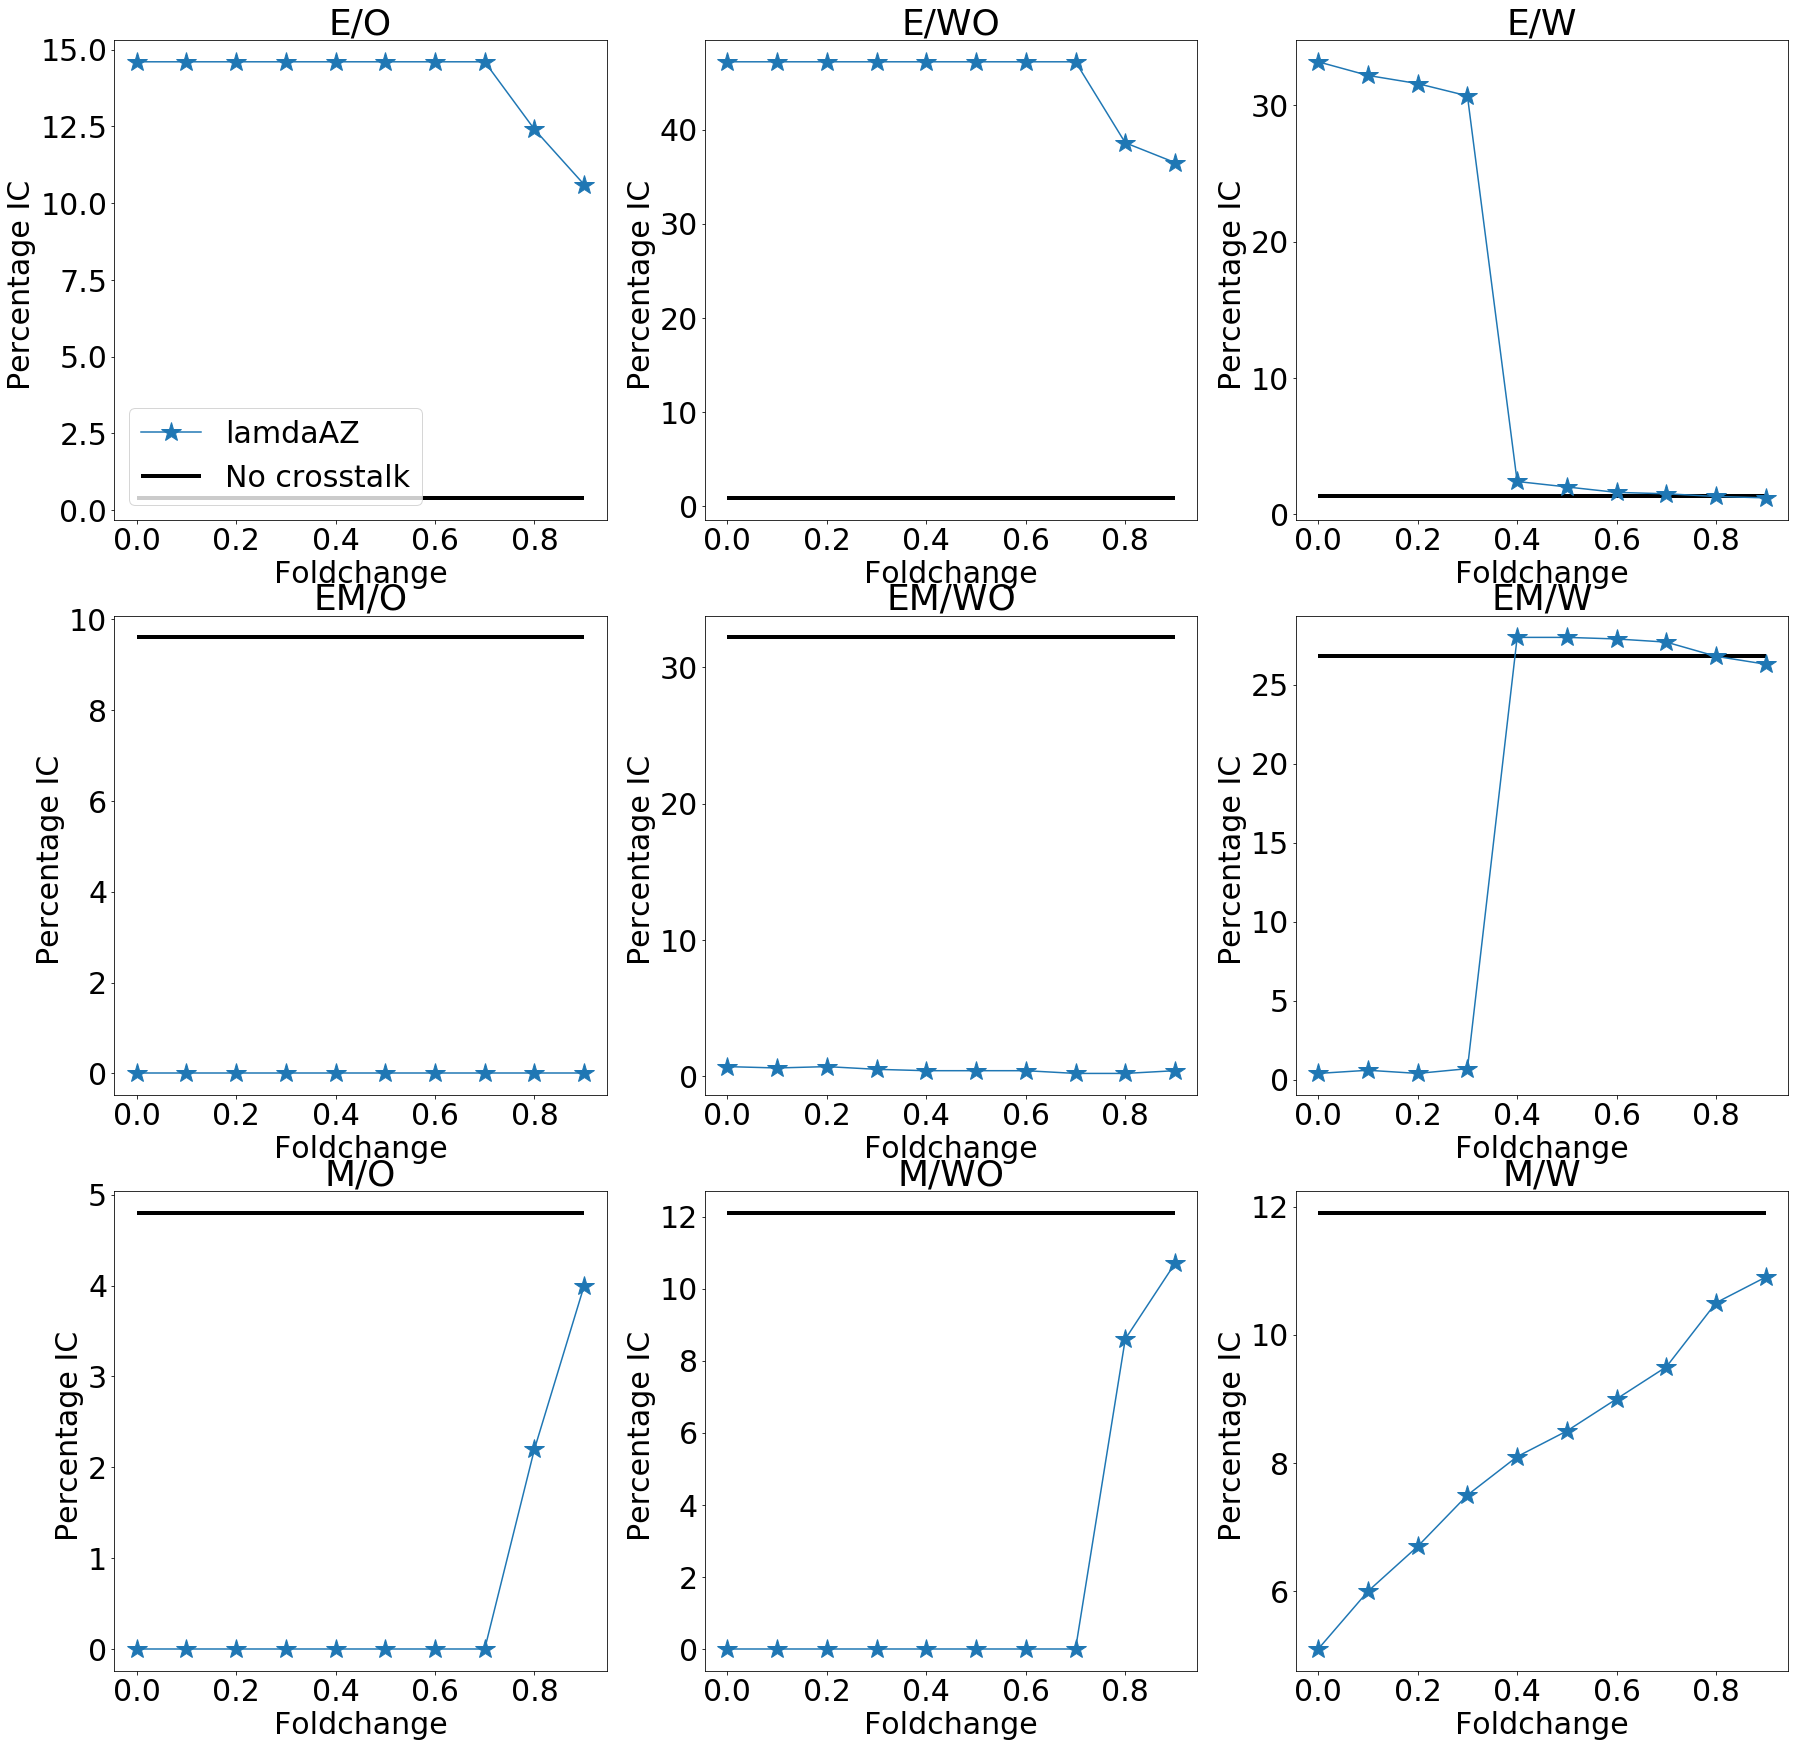

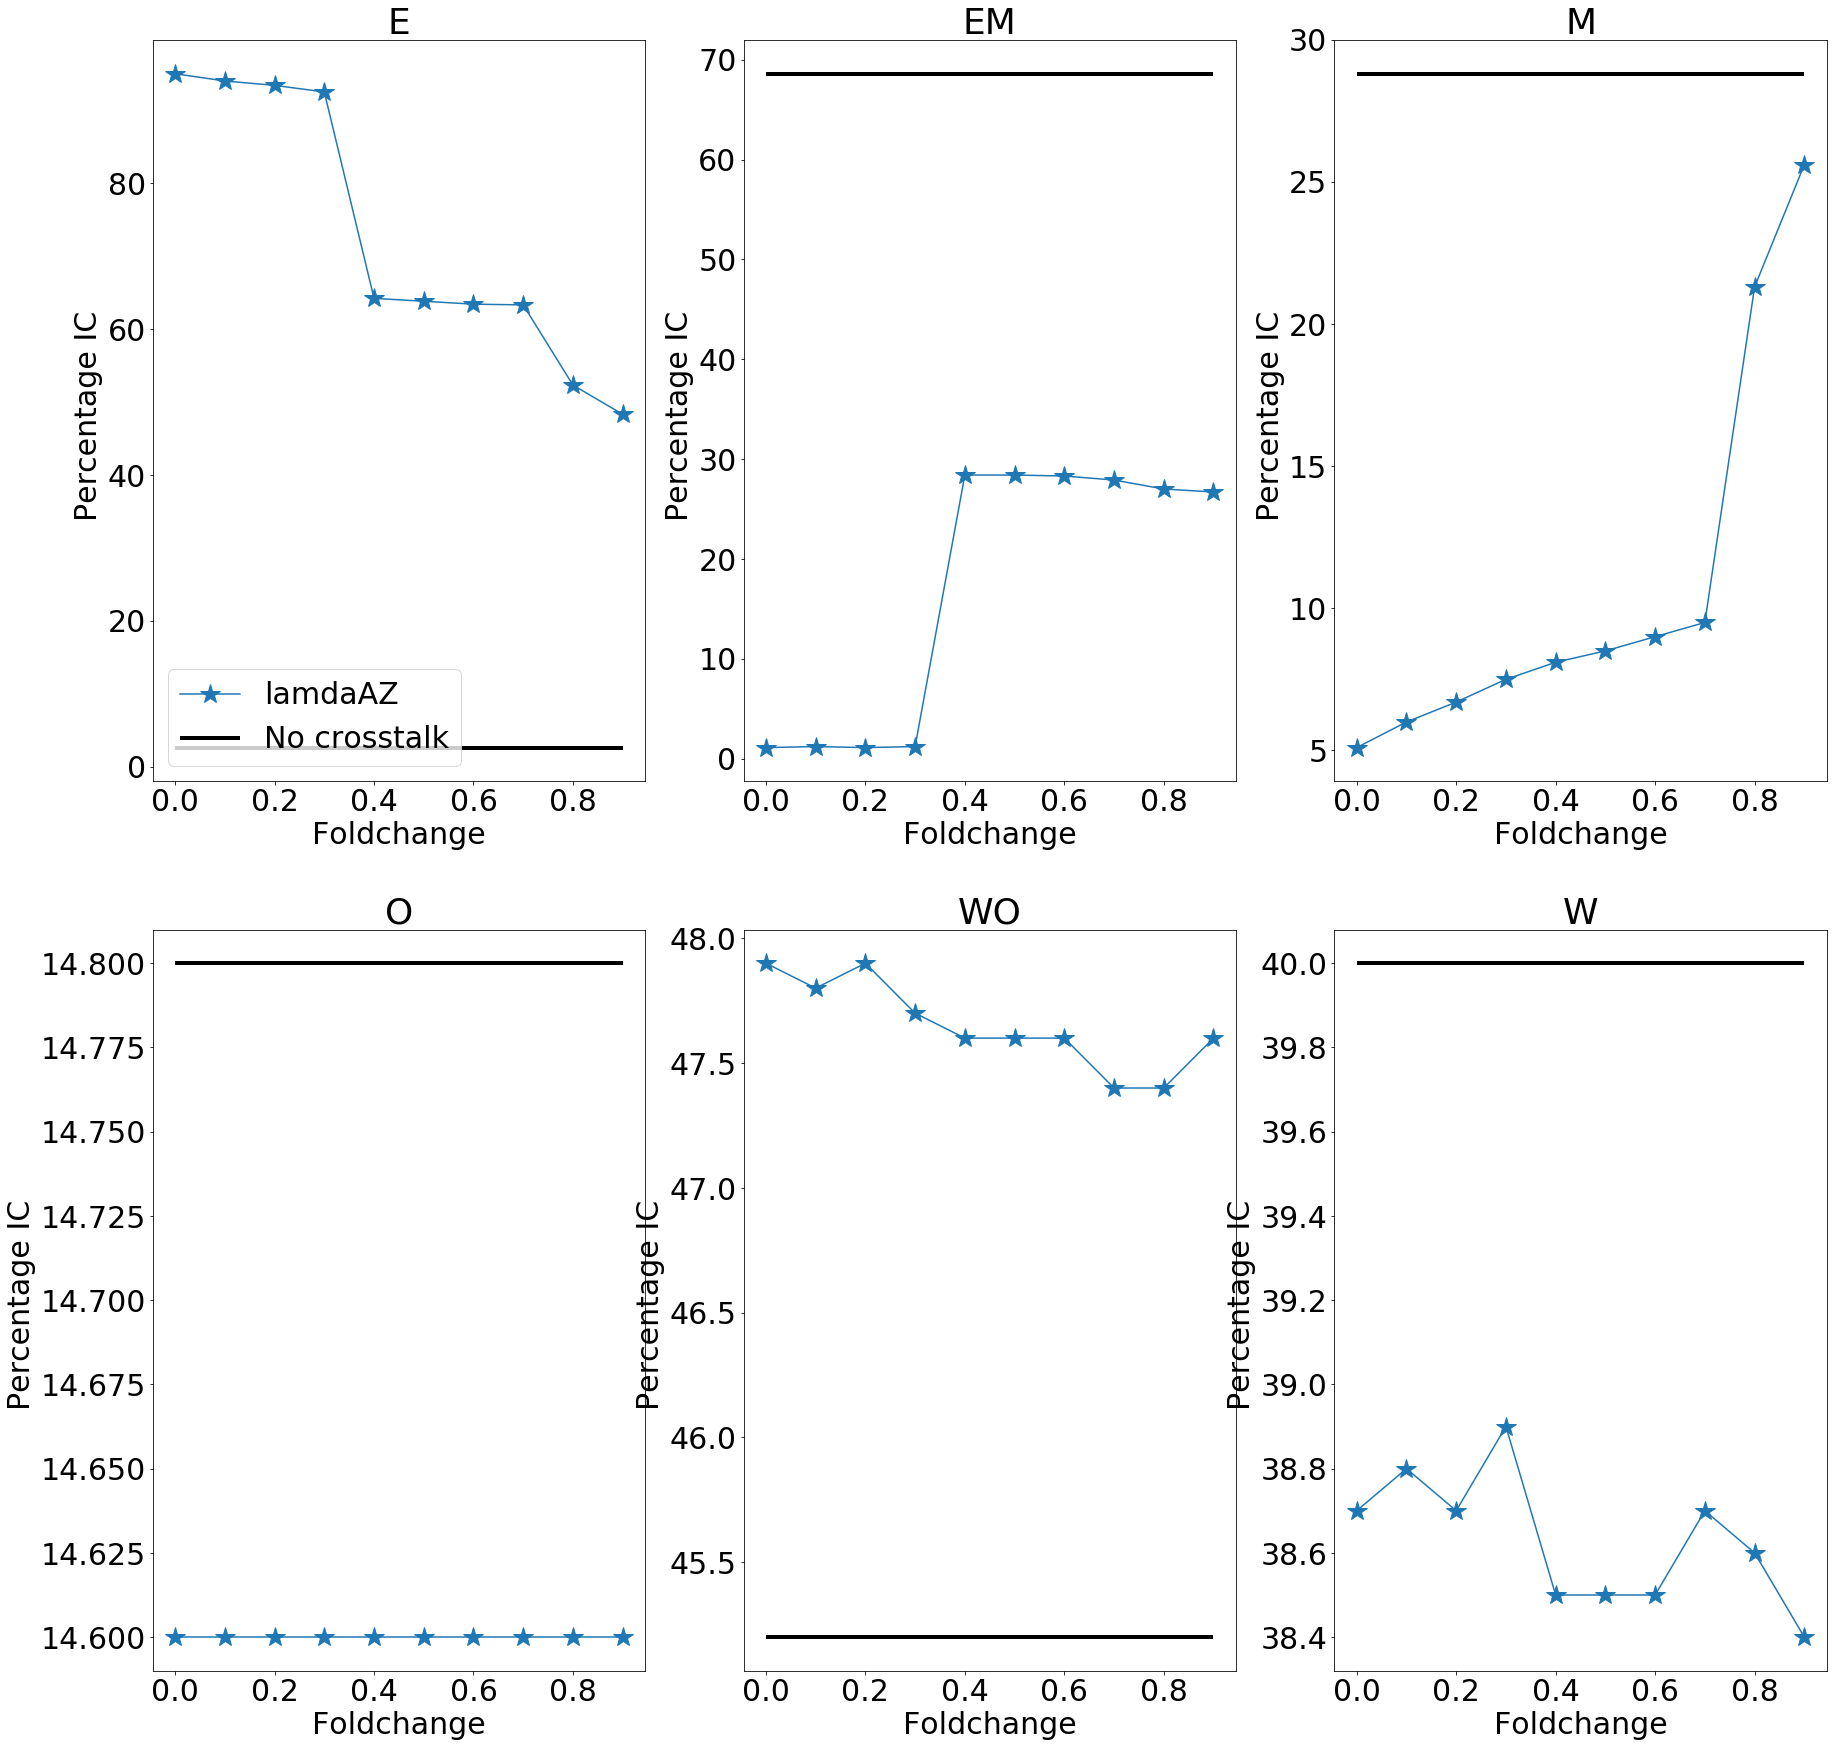

lamdaHS


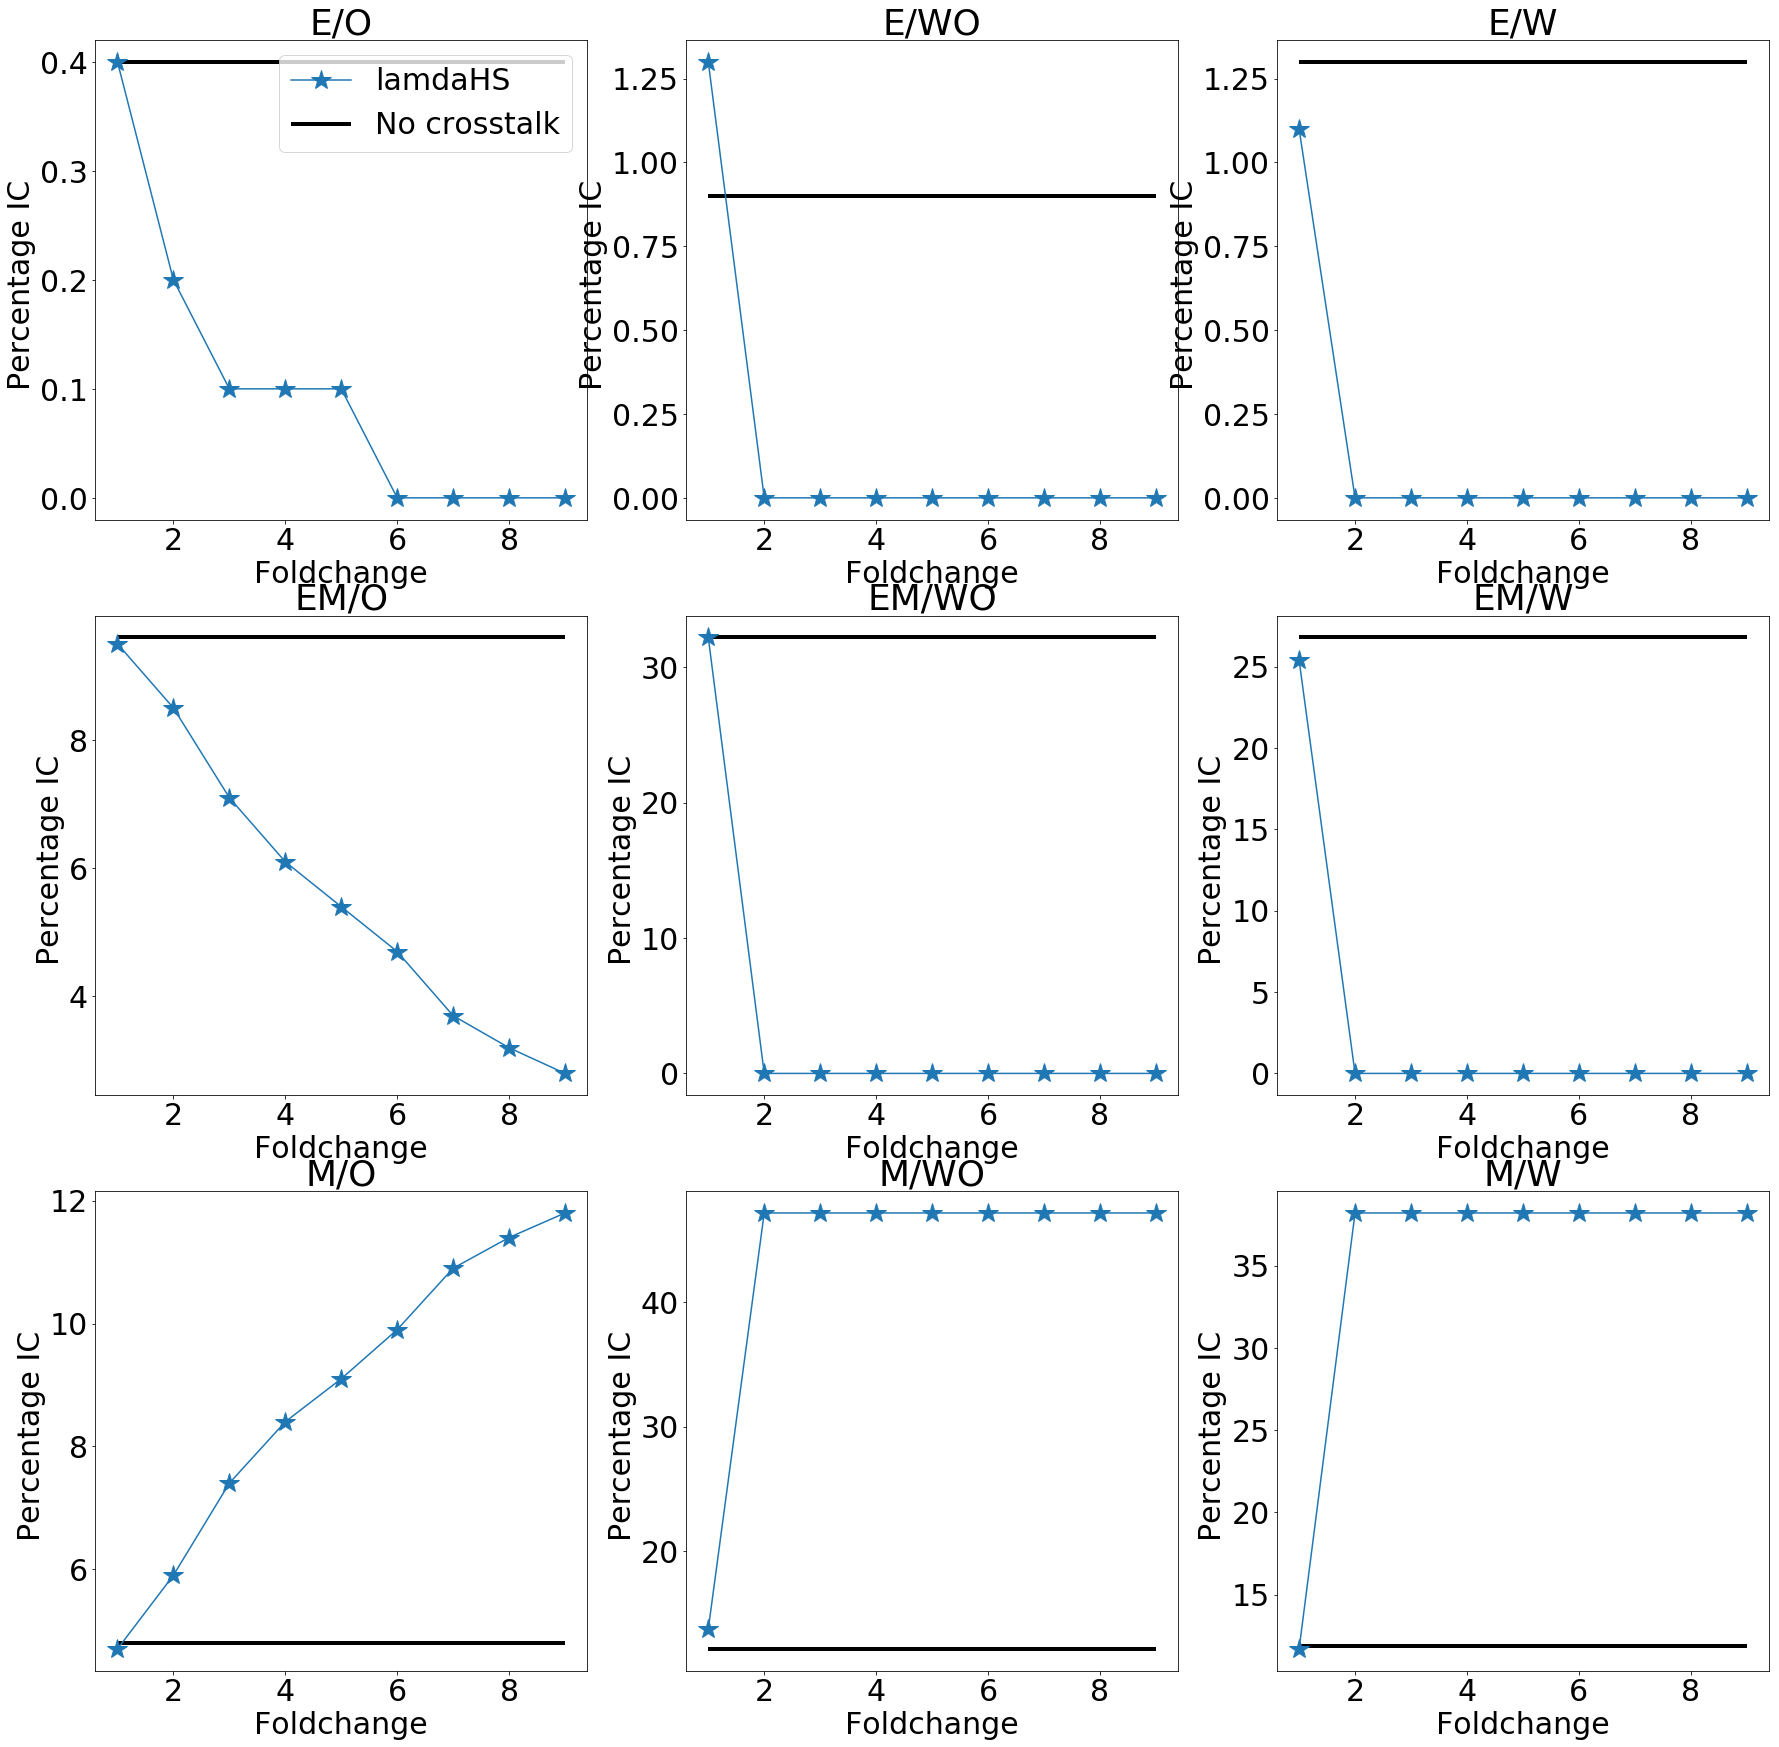

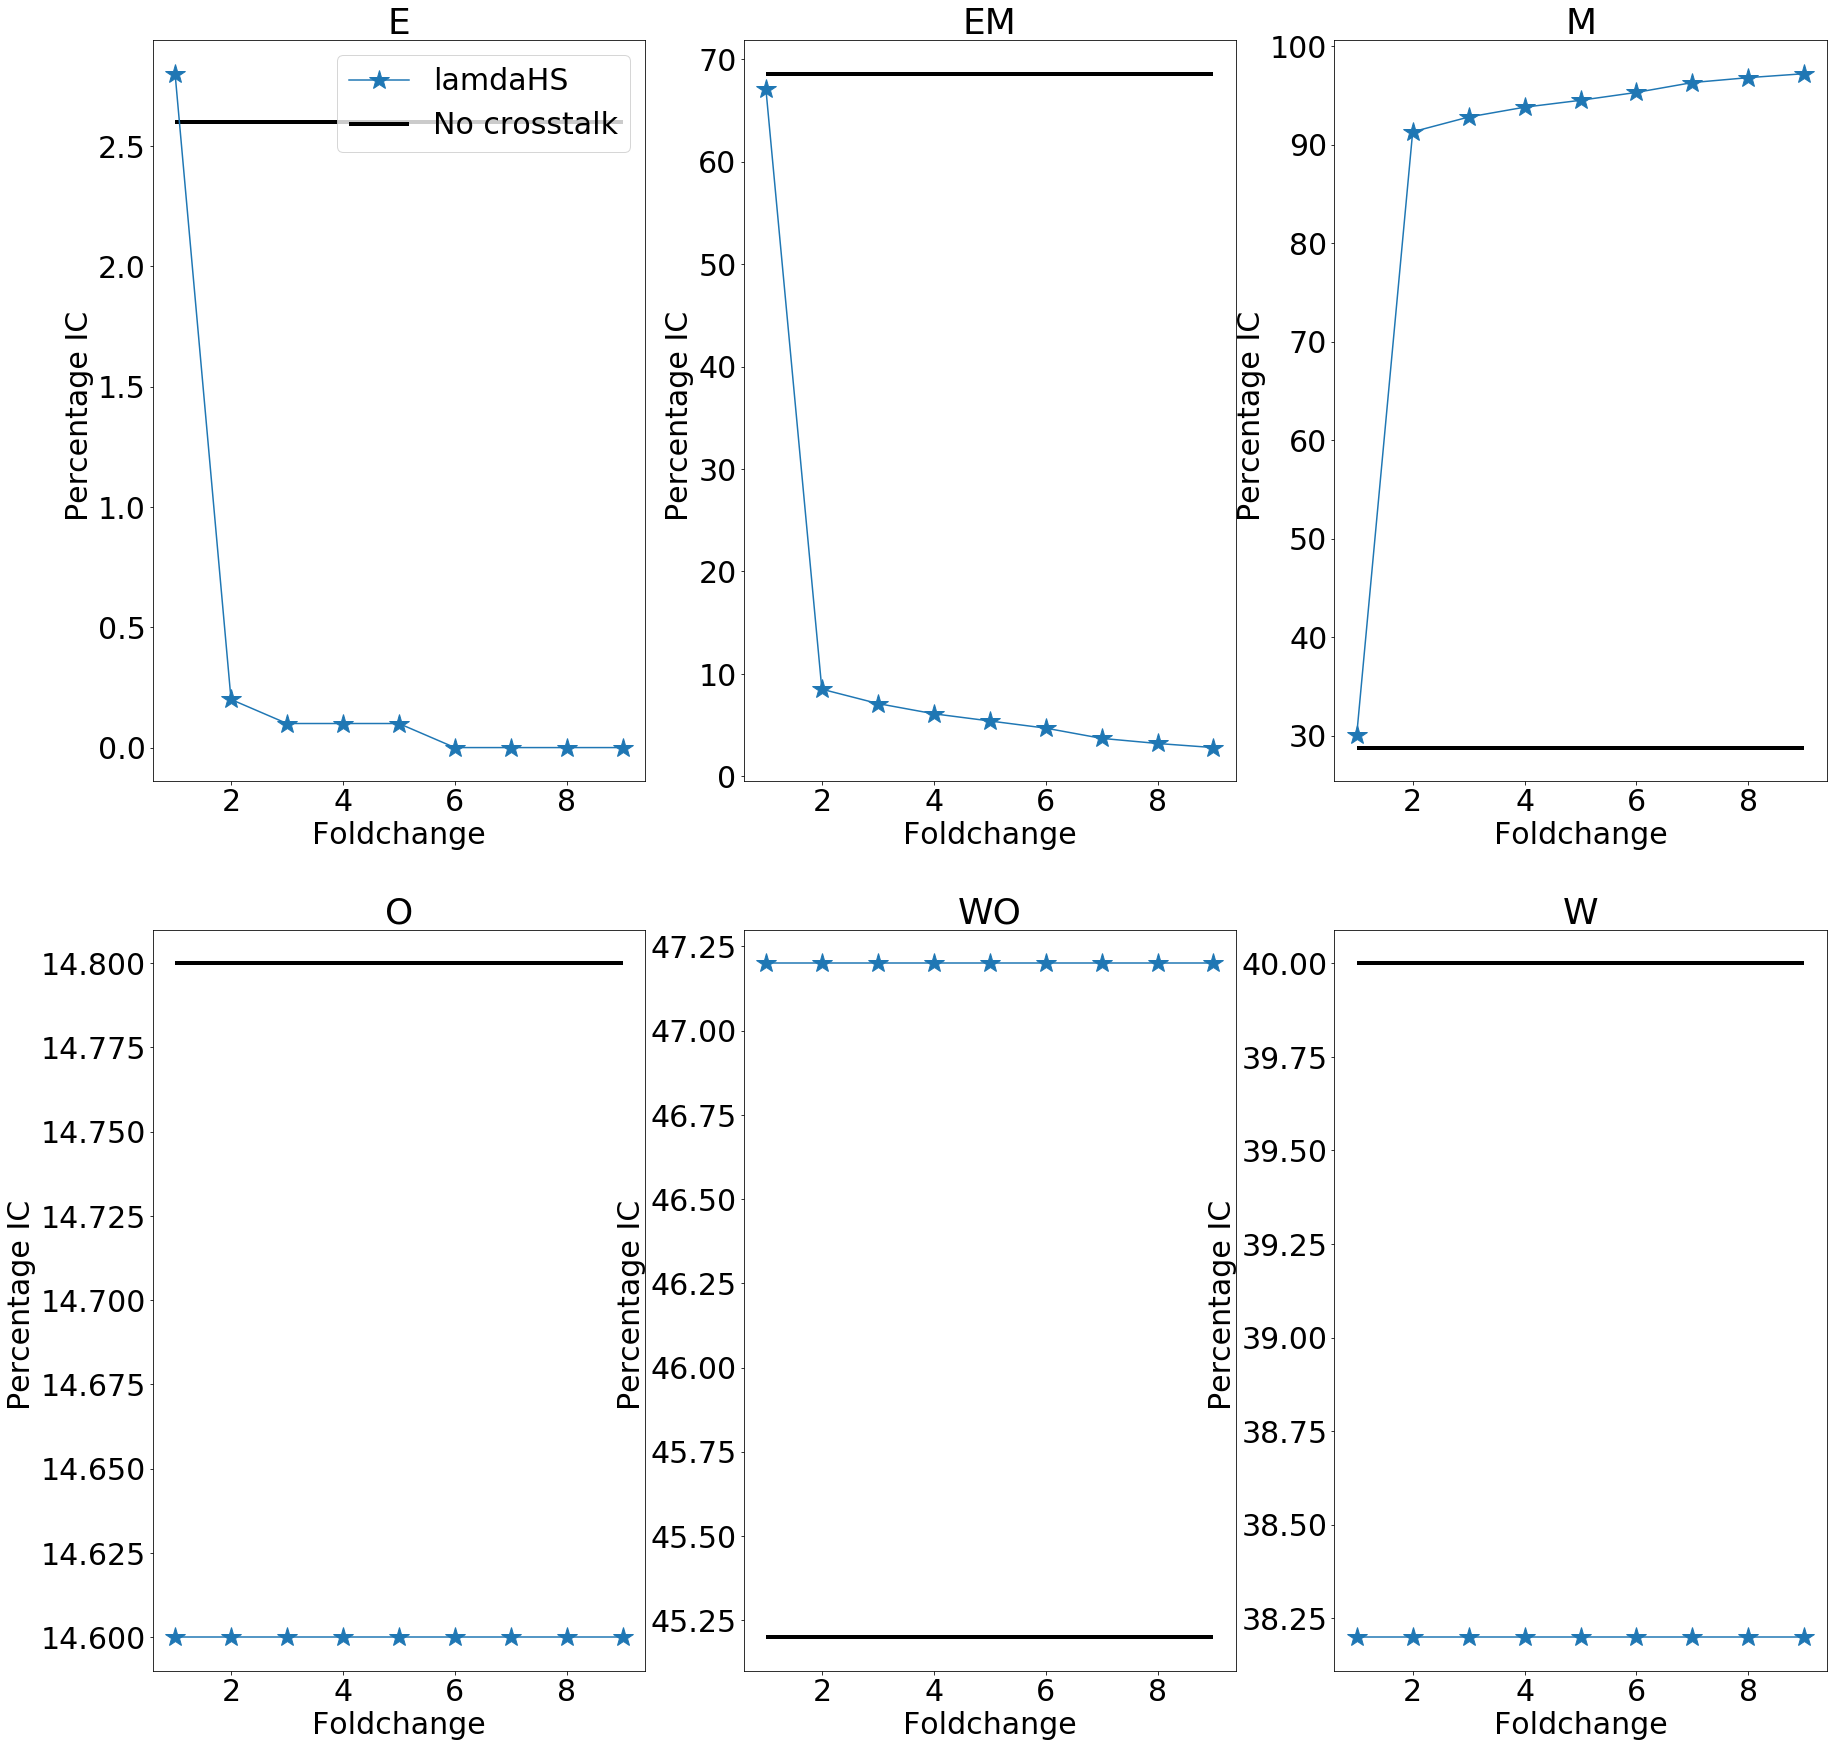

lamdau3Rm


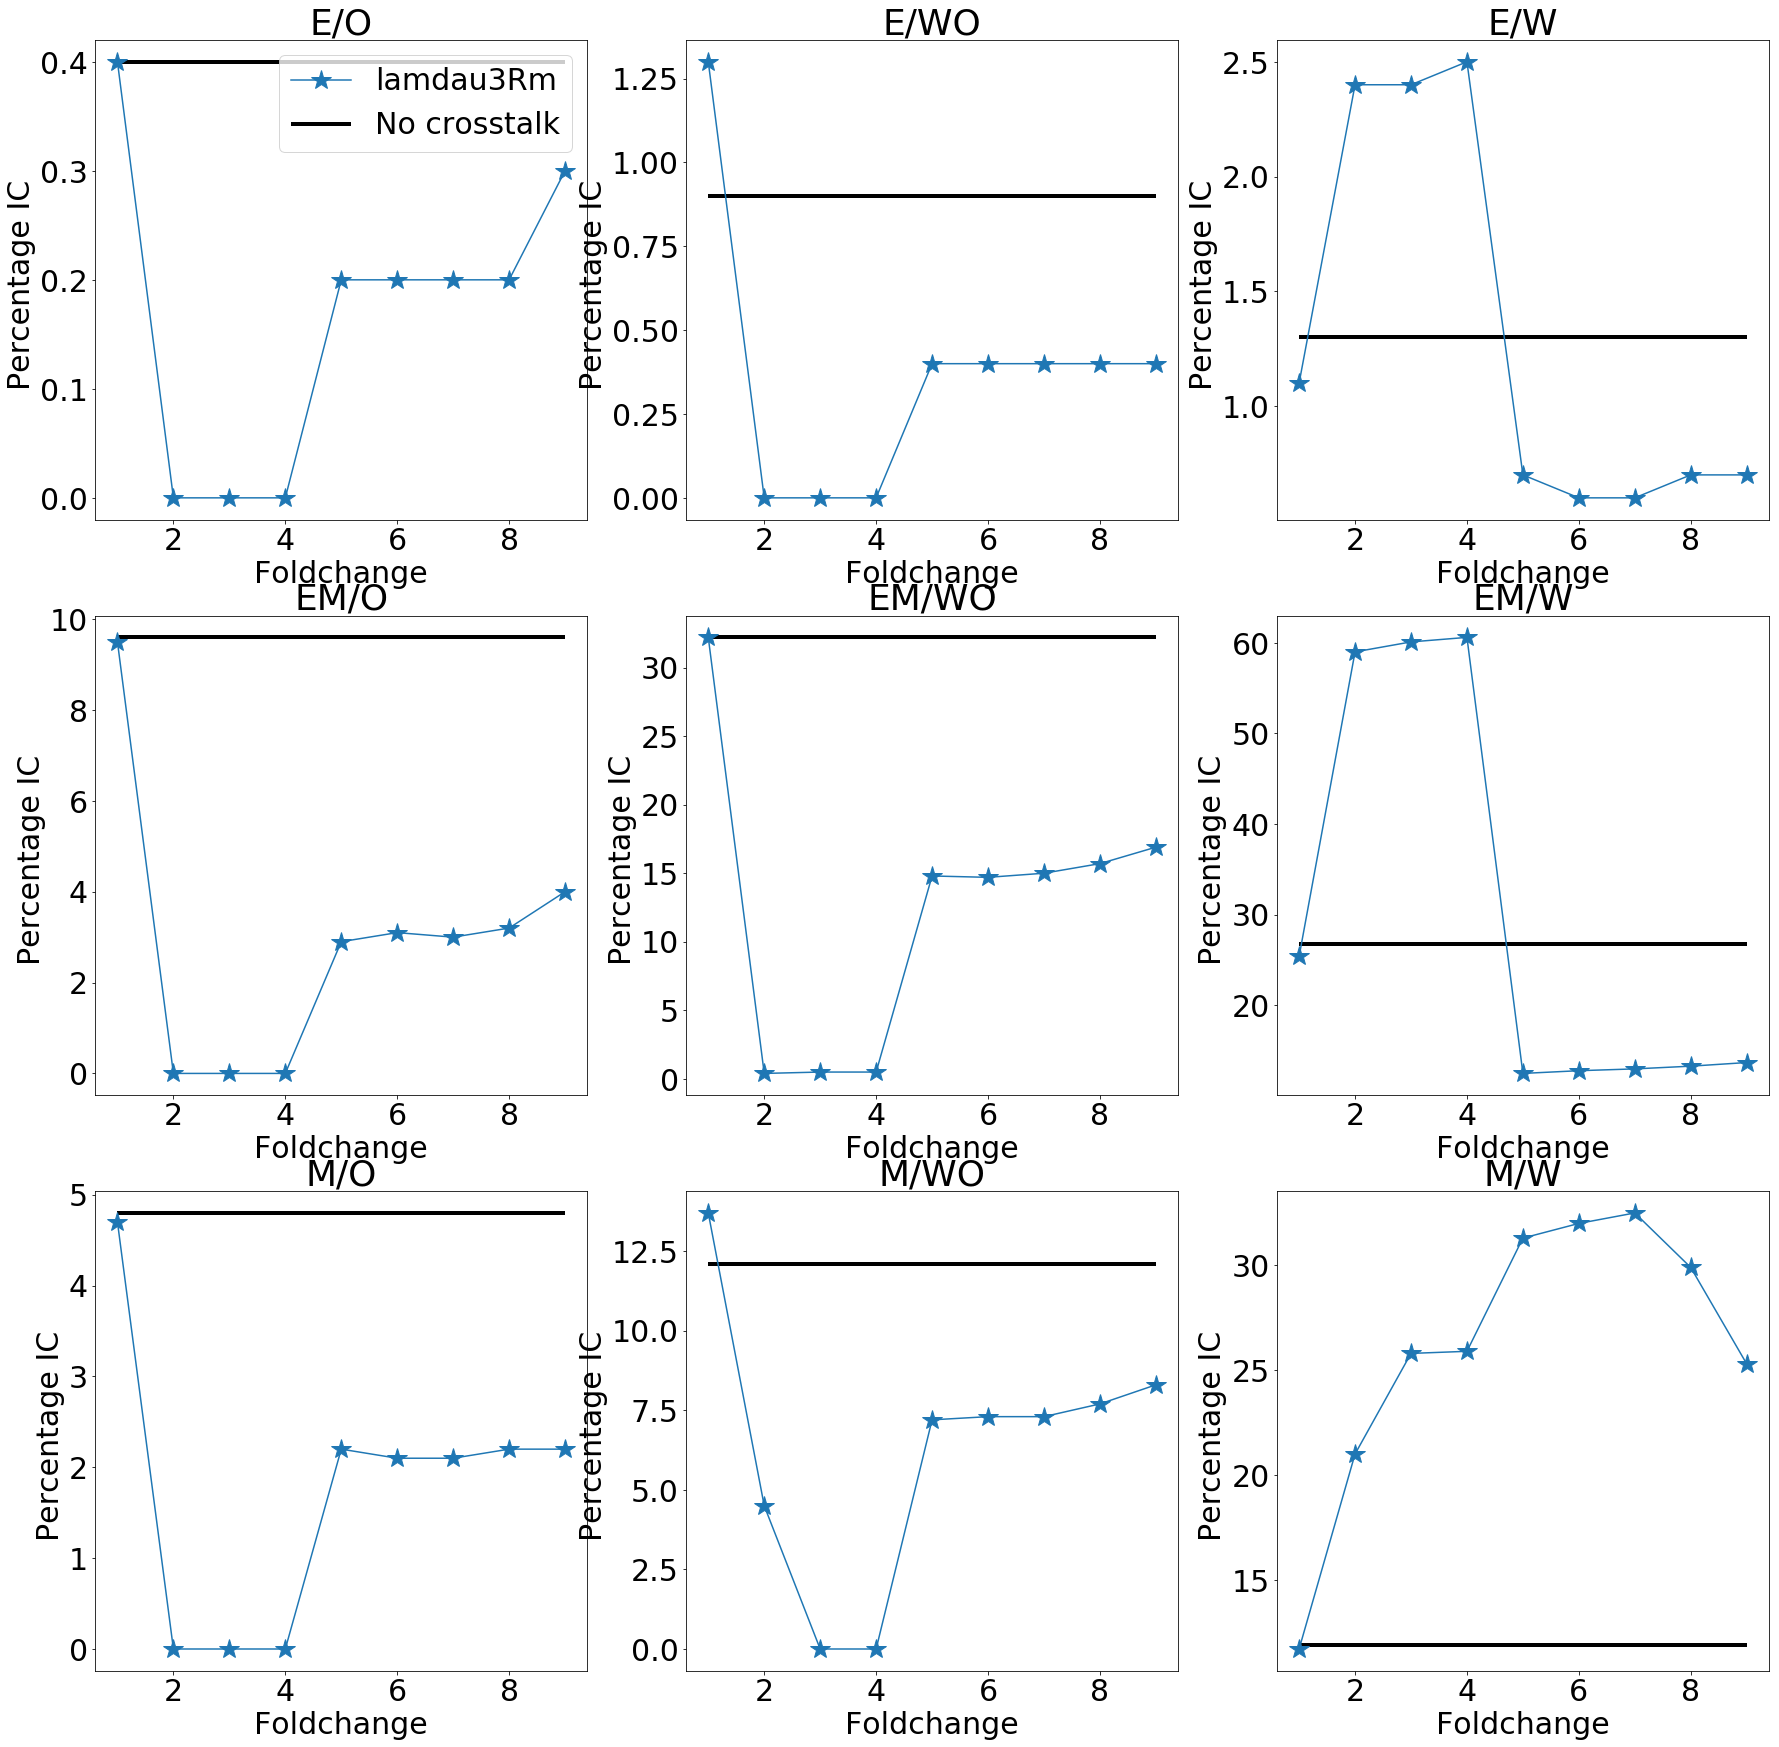

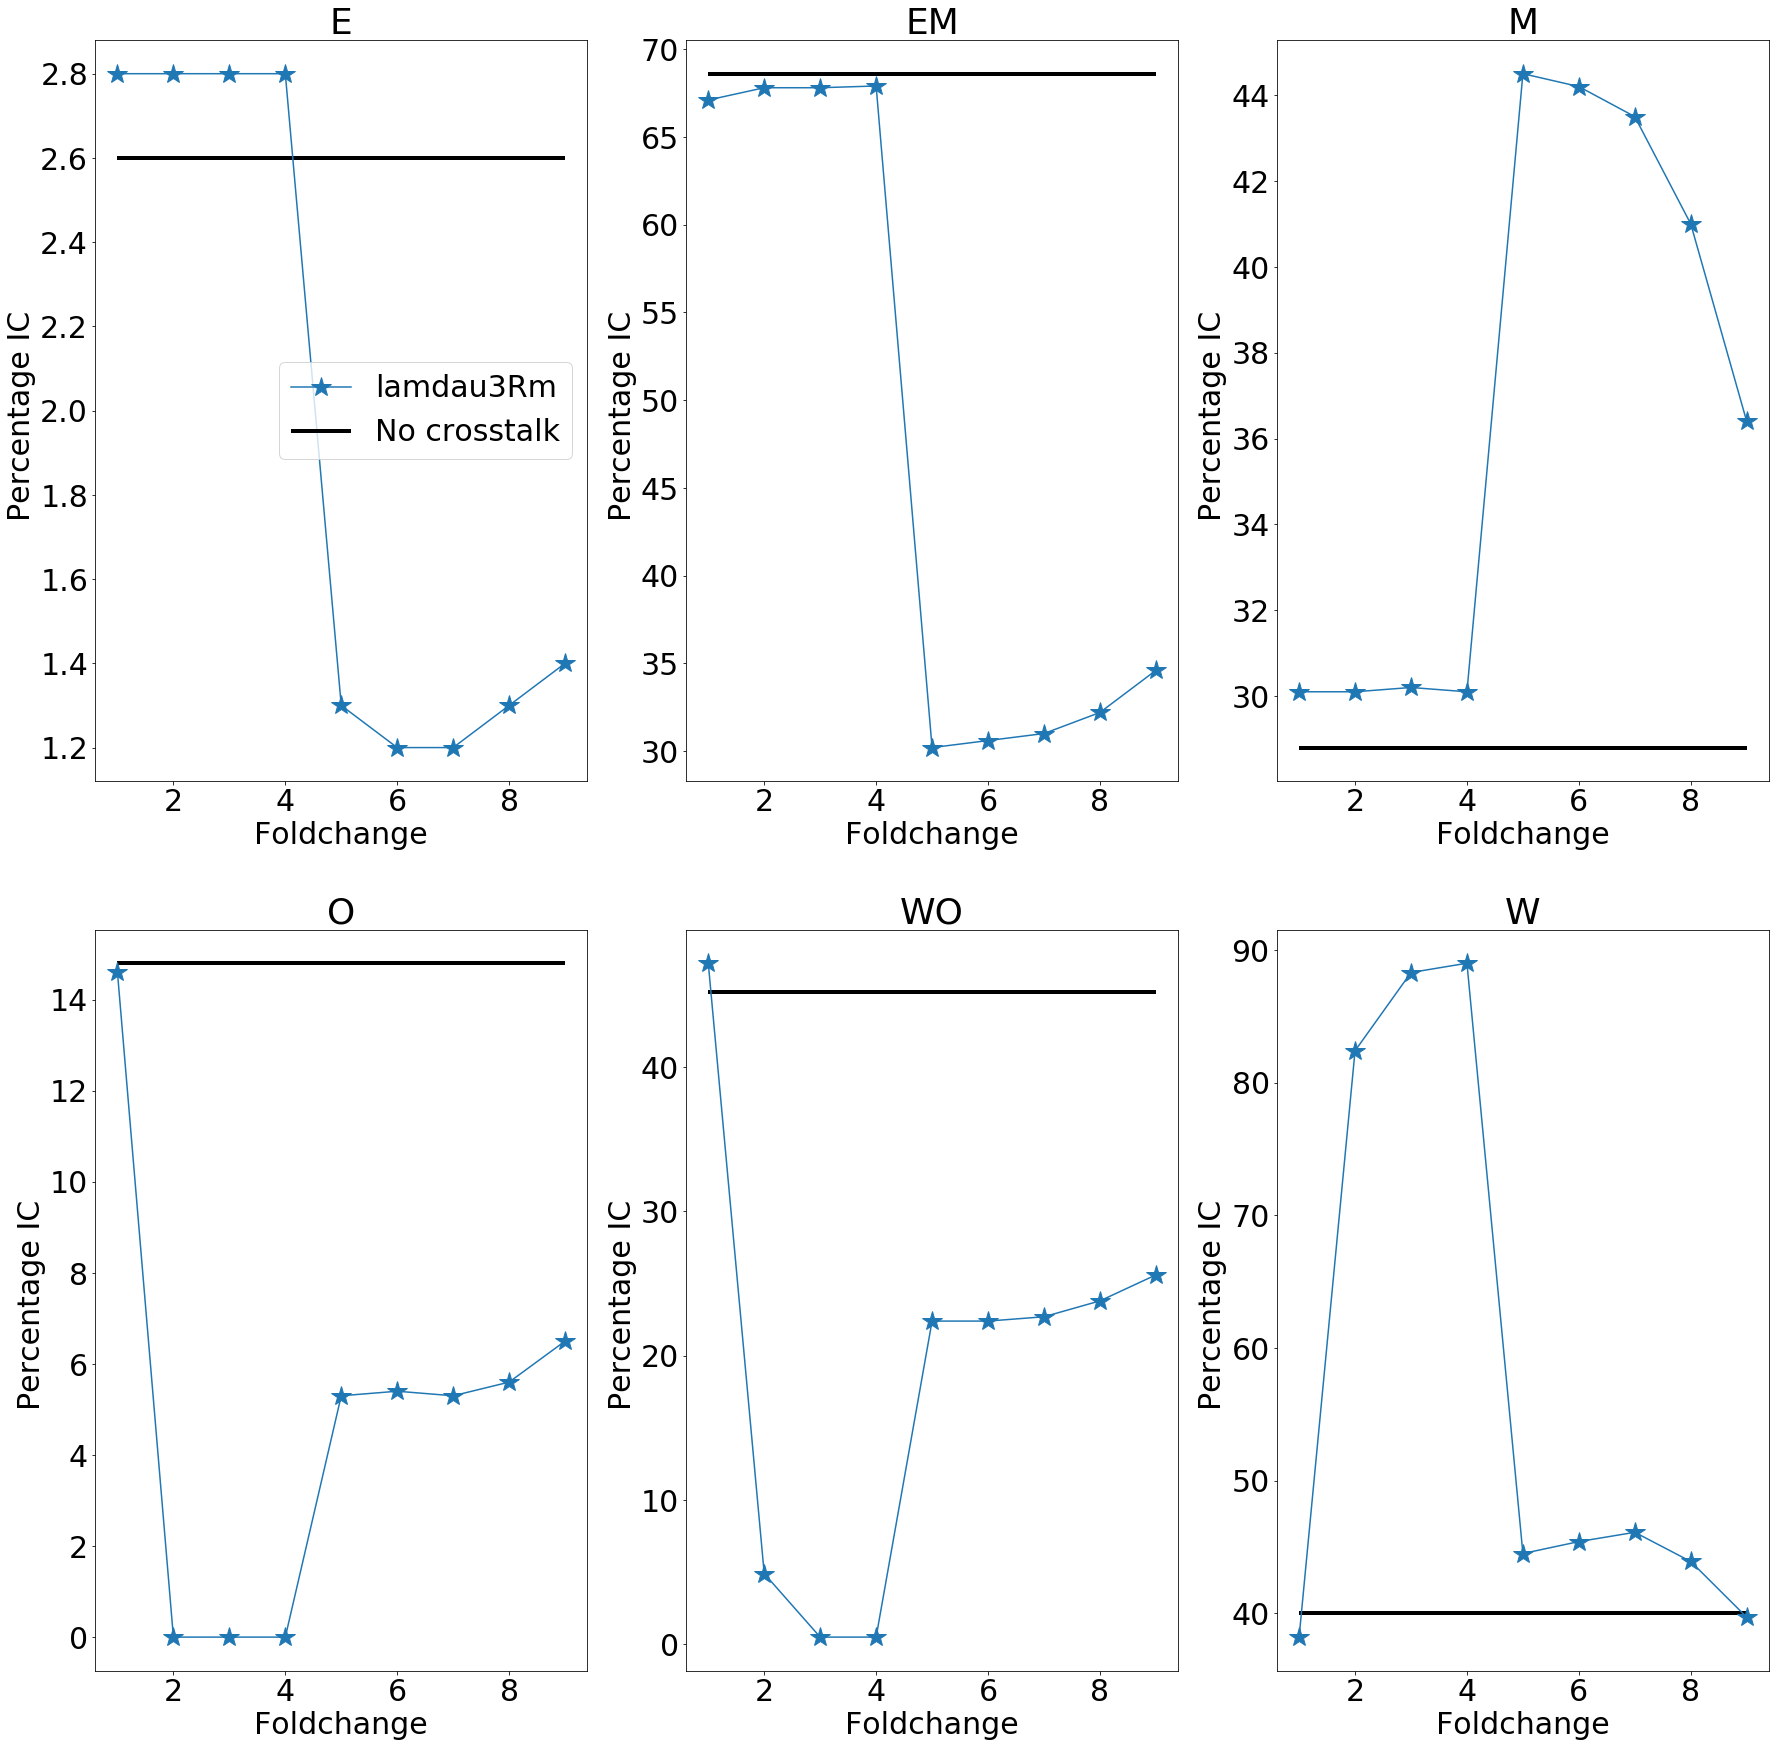

lamdau3Rn
error with coupledWReg_Ccode/crosstalk_singles/EMT_MR_lamdau3Rn7_1000_res.txt
error with coupledWReg_Ccode/crosstalk_singles/EMT_MR_lamdau3Rn6_1000_res.txt


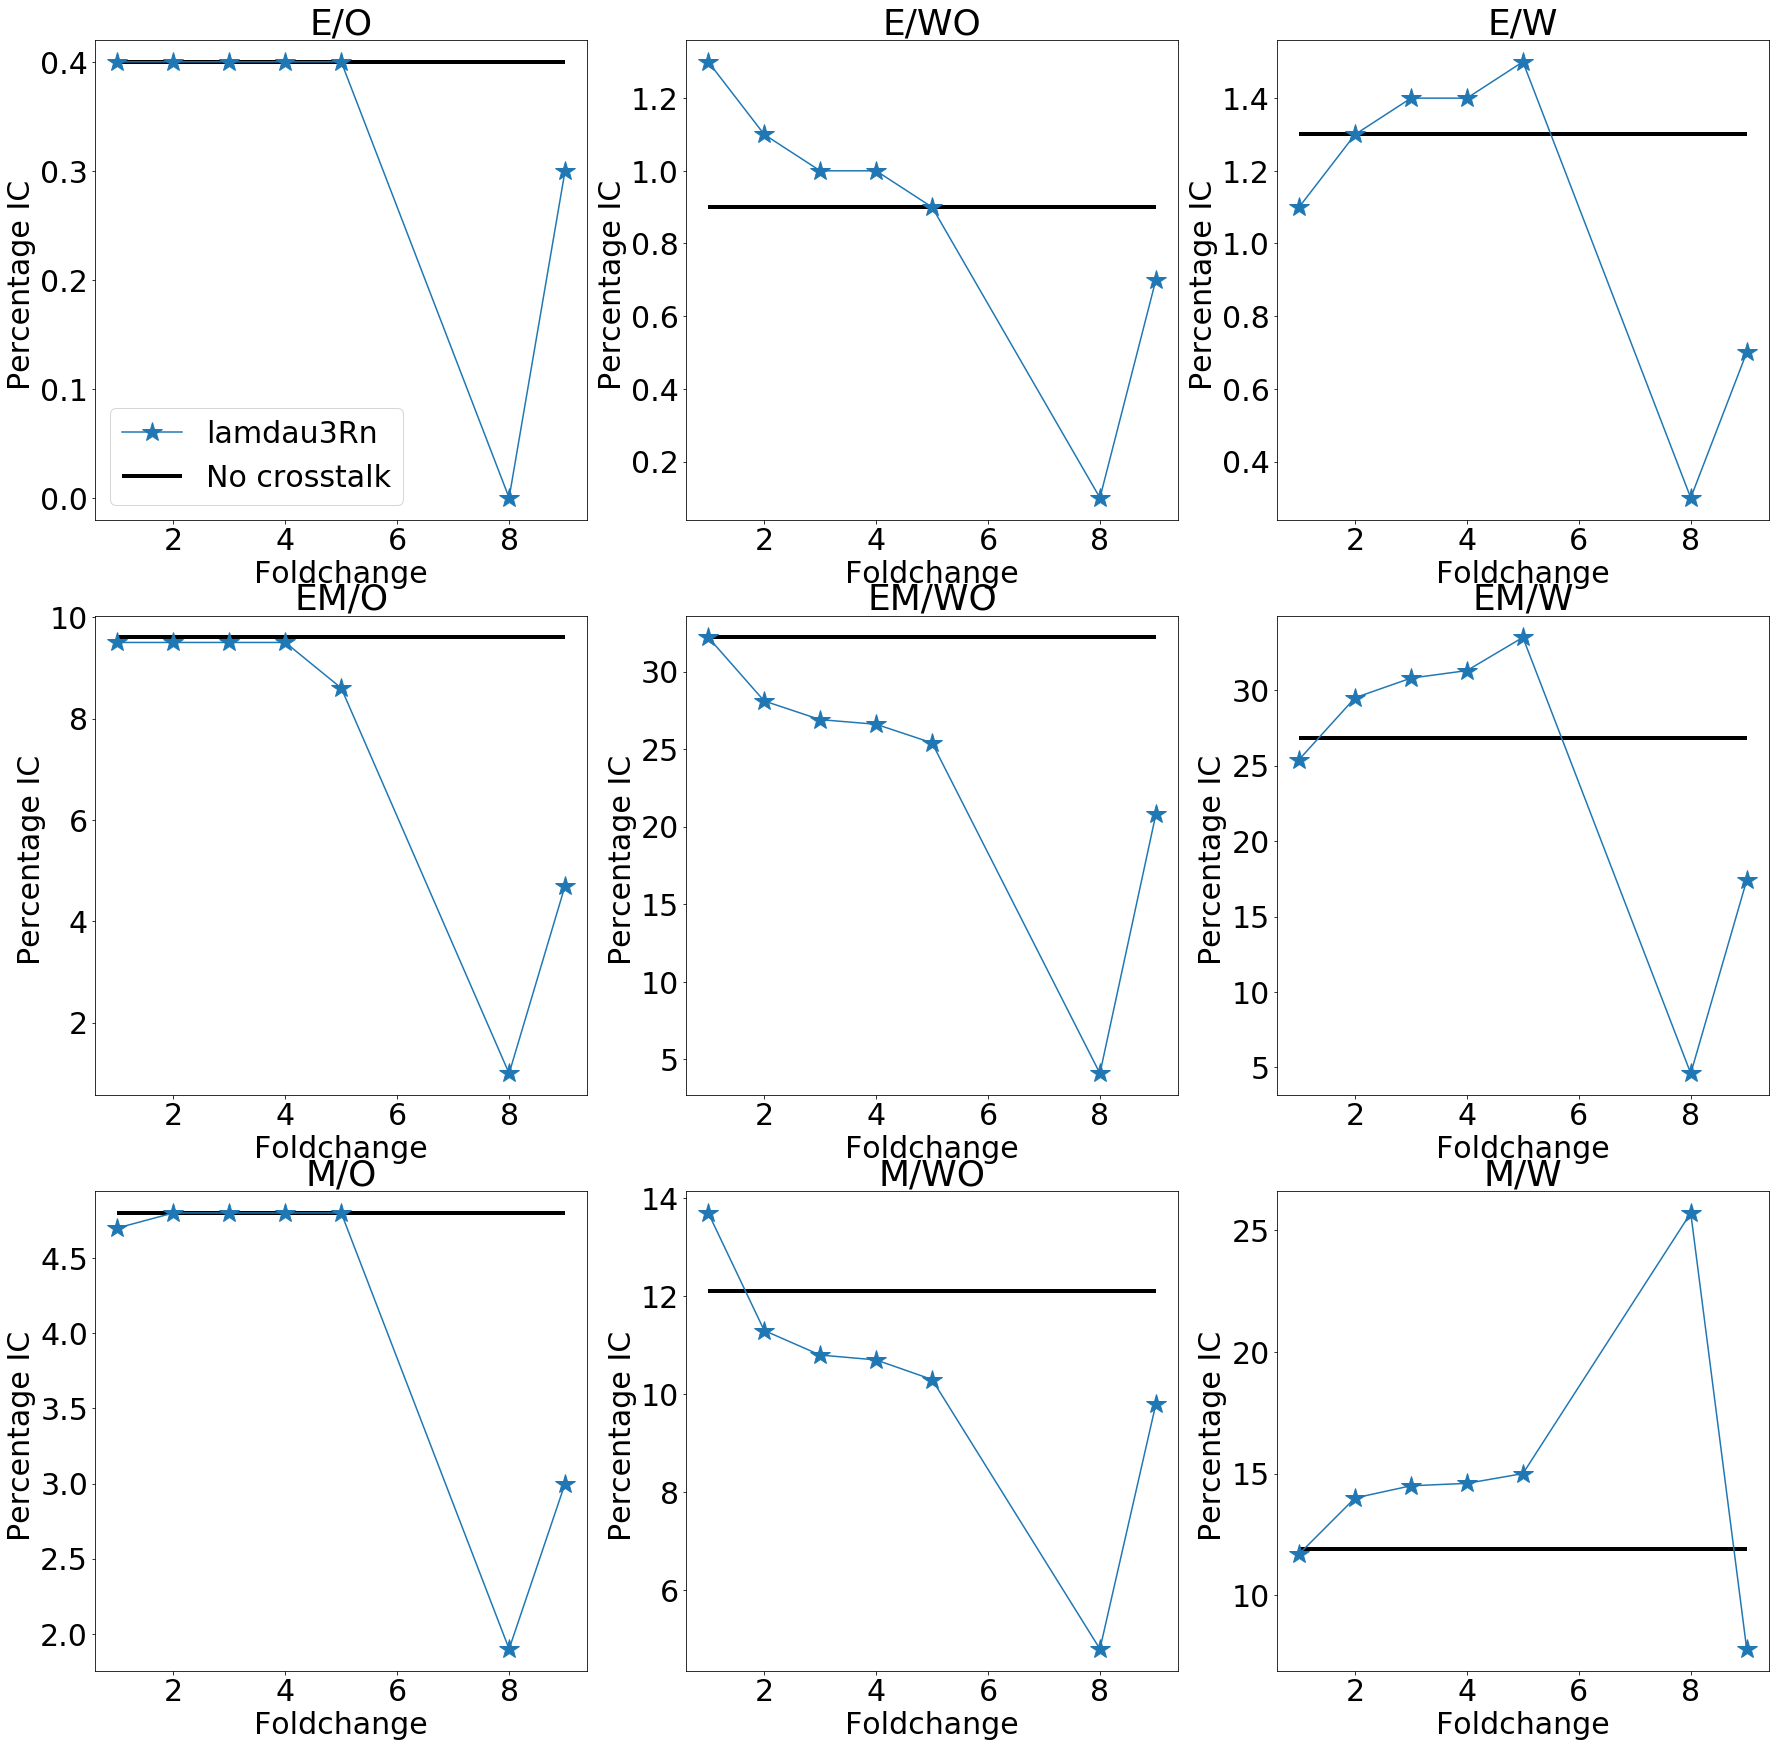

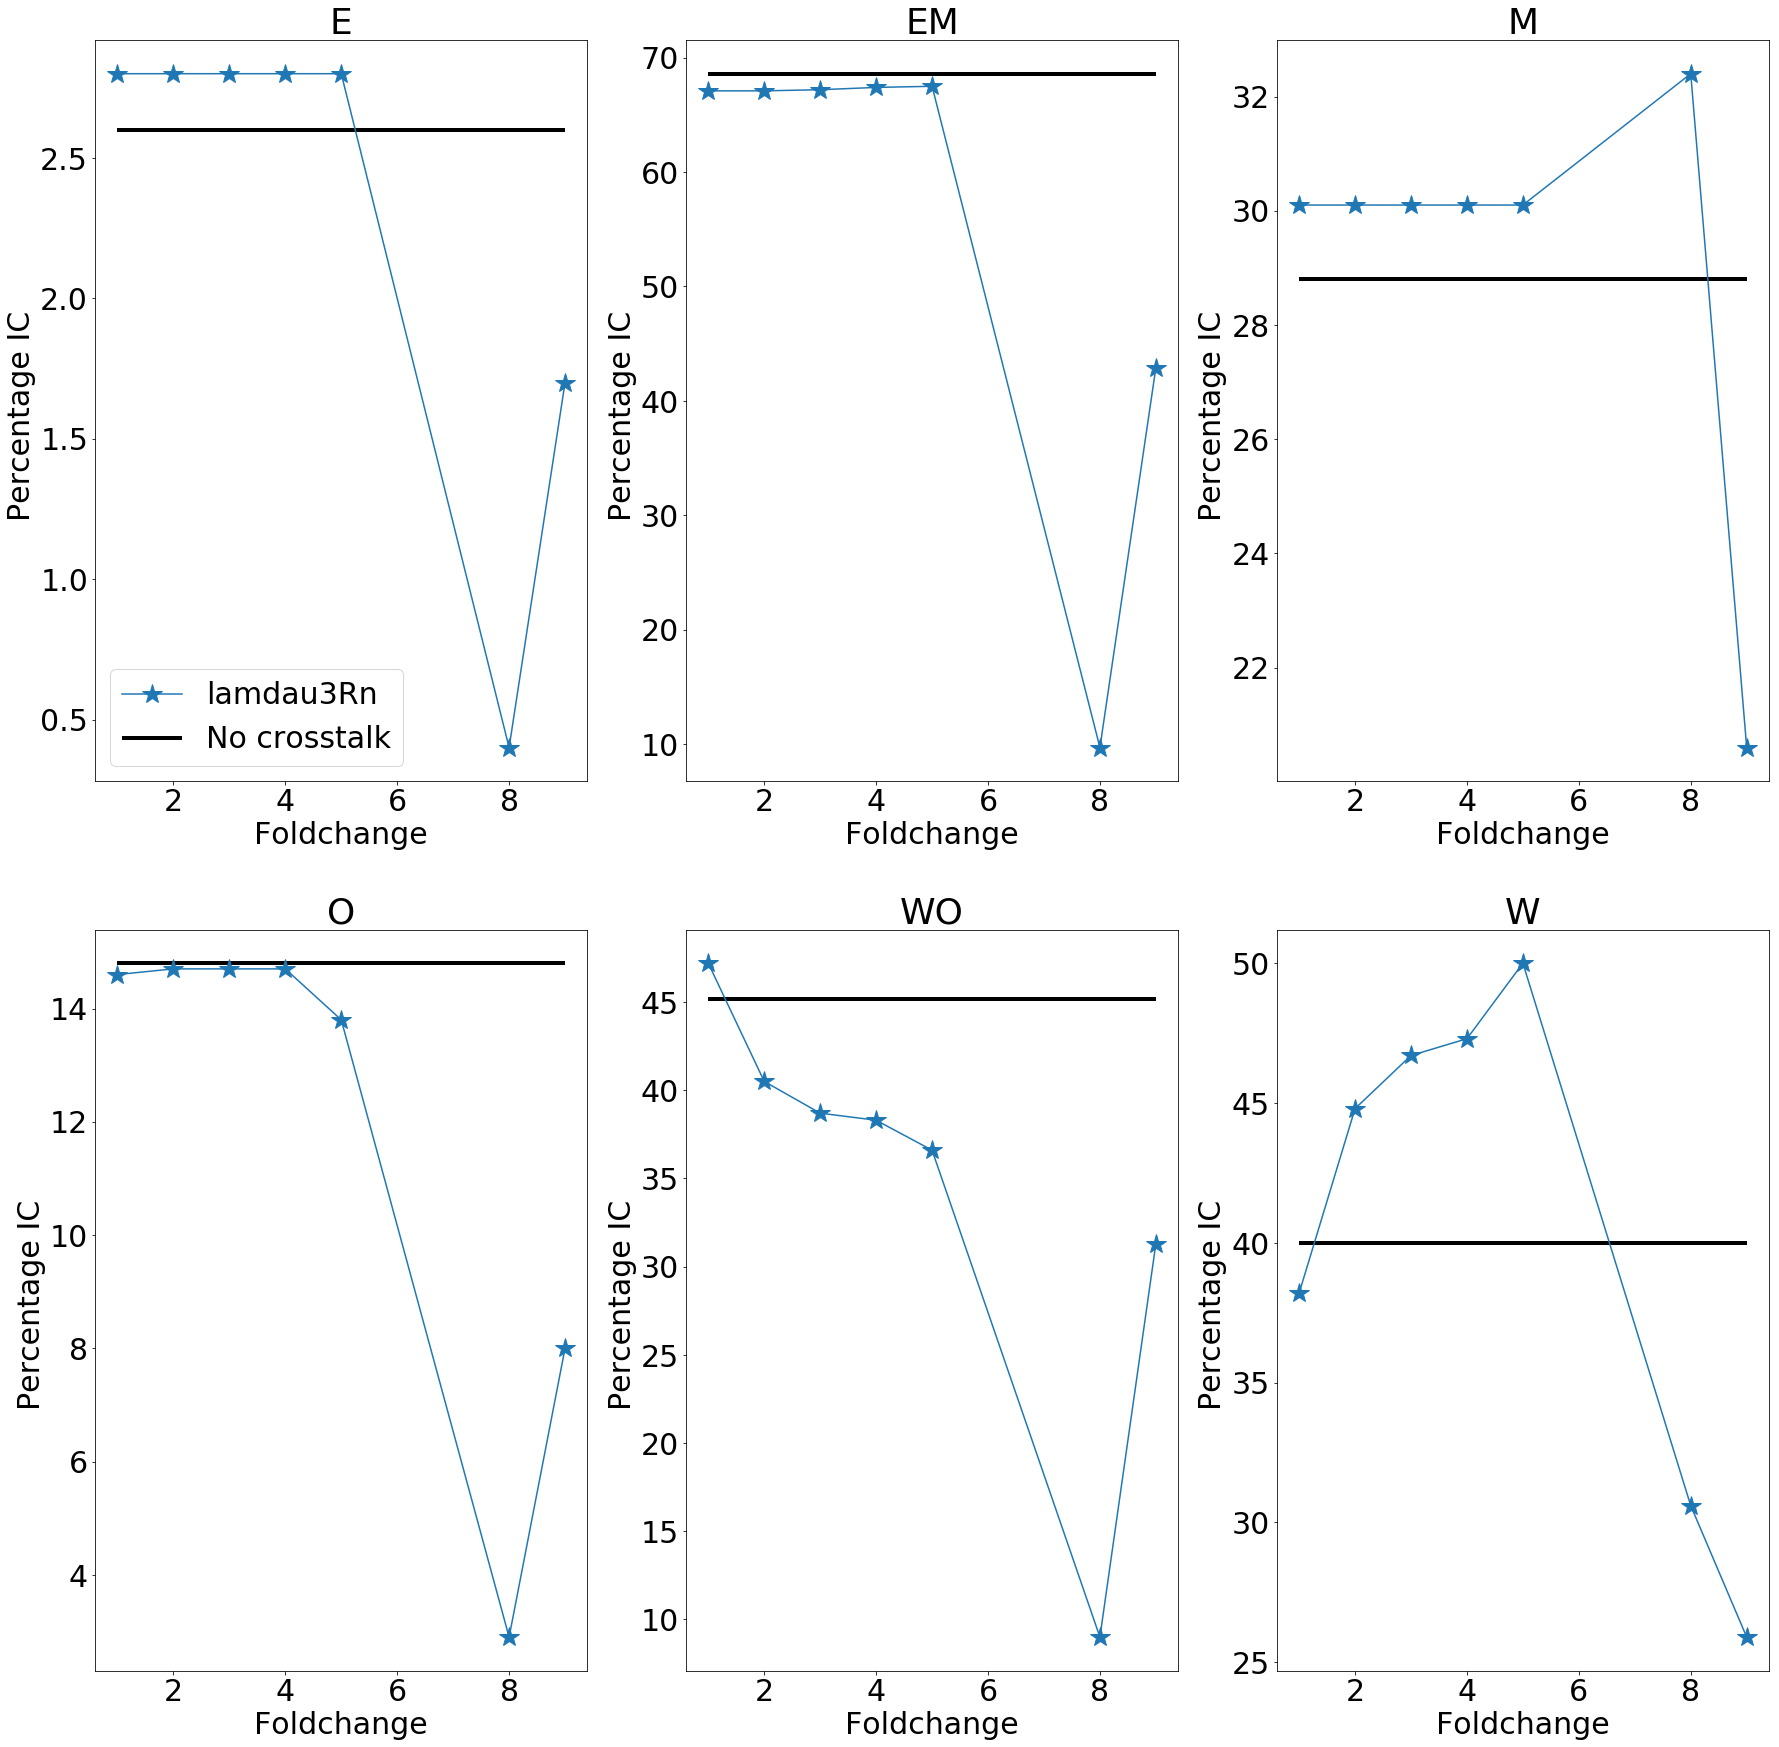

lamdaAS


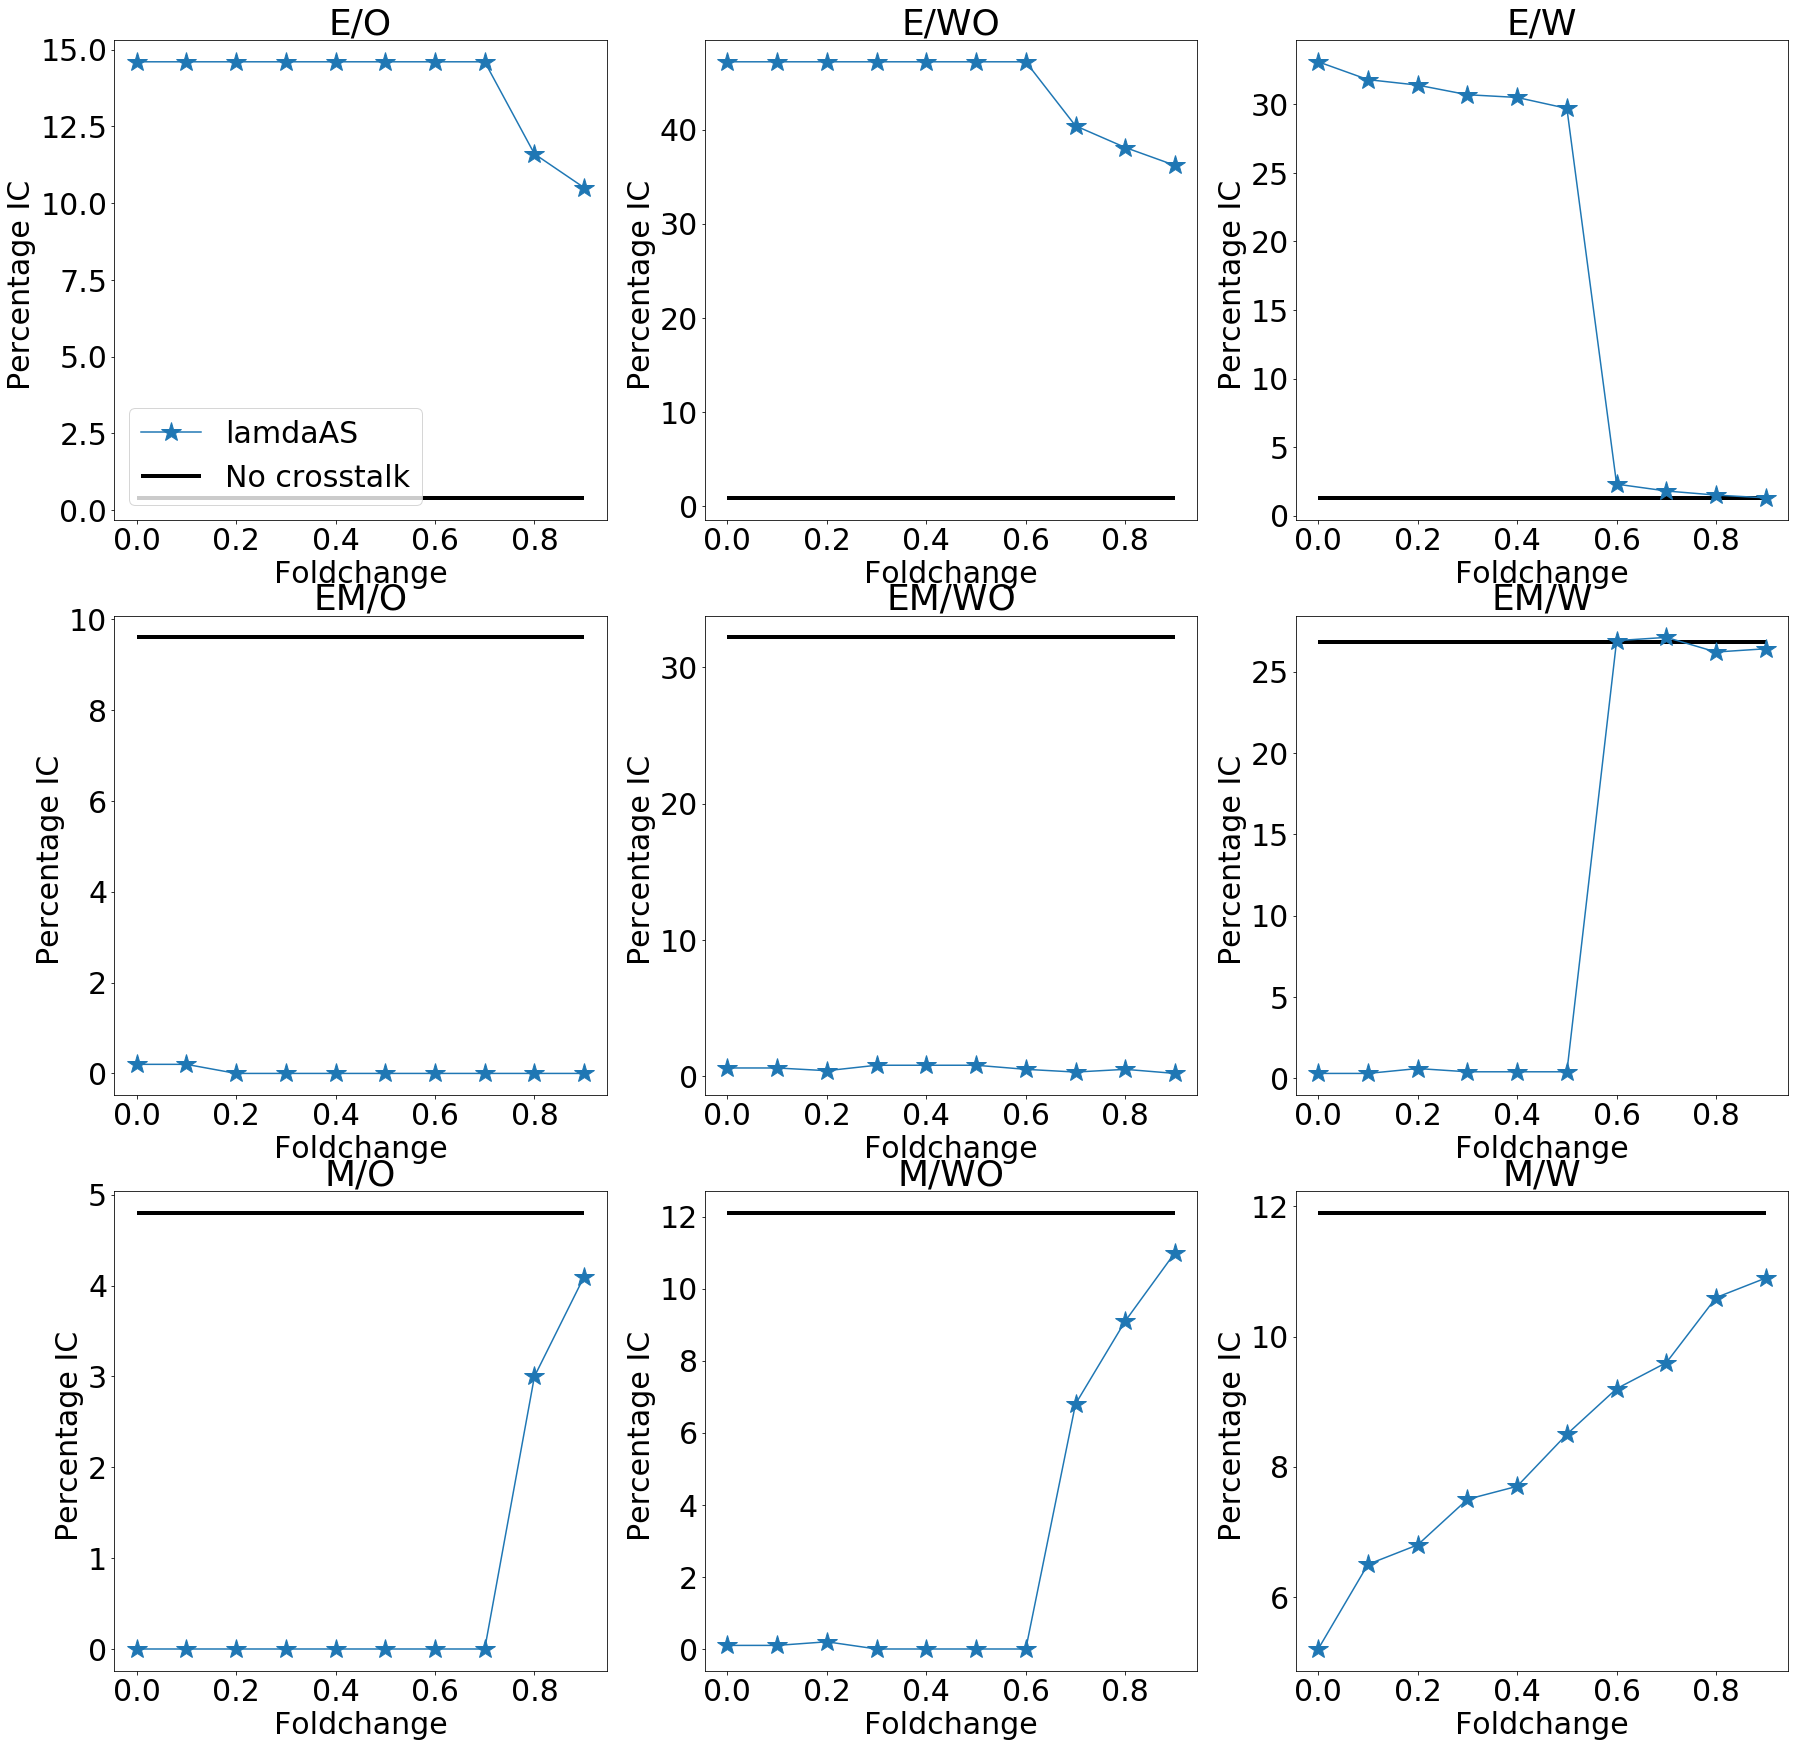

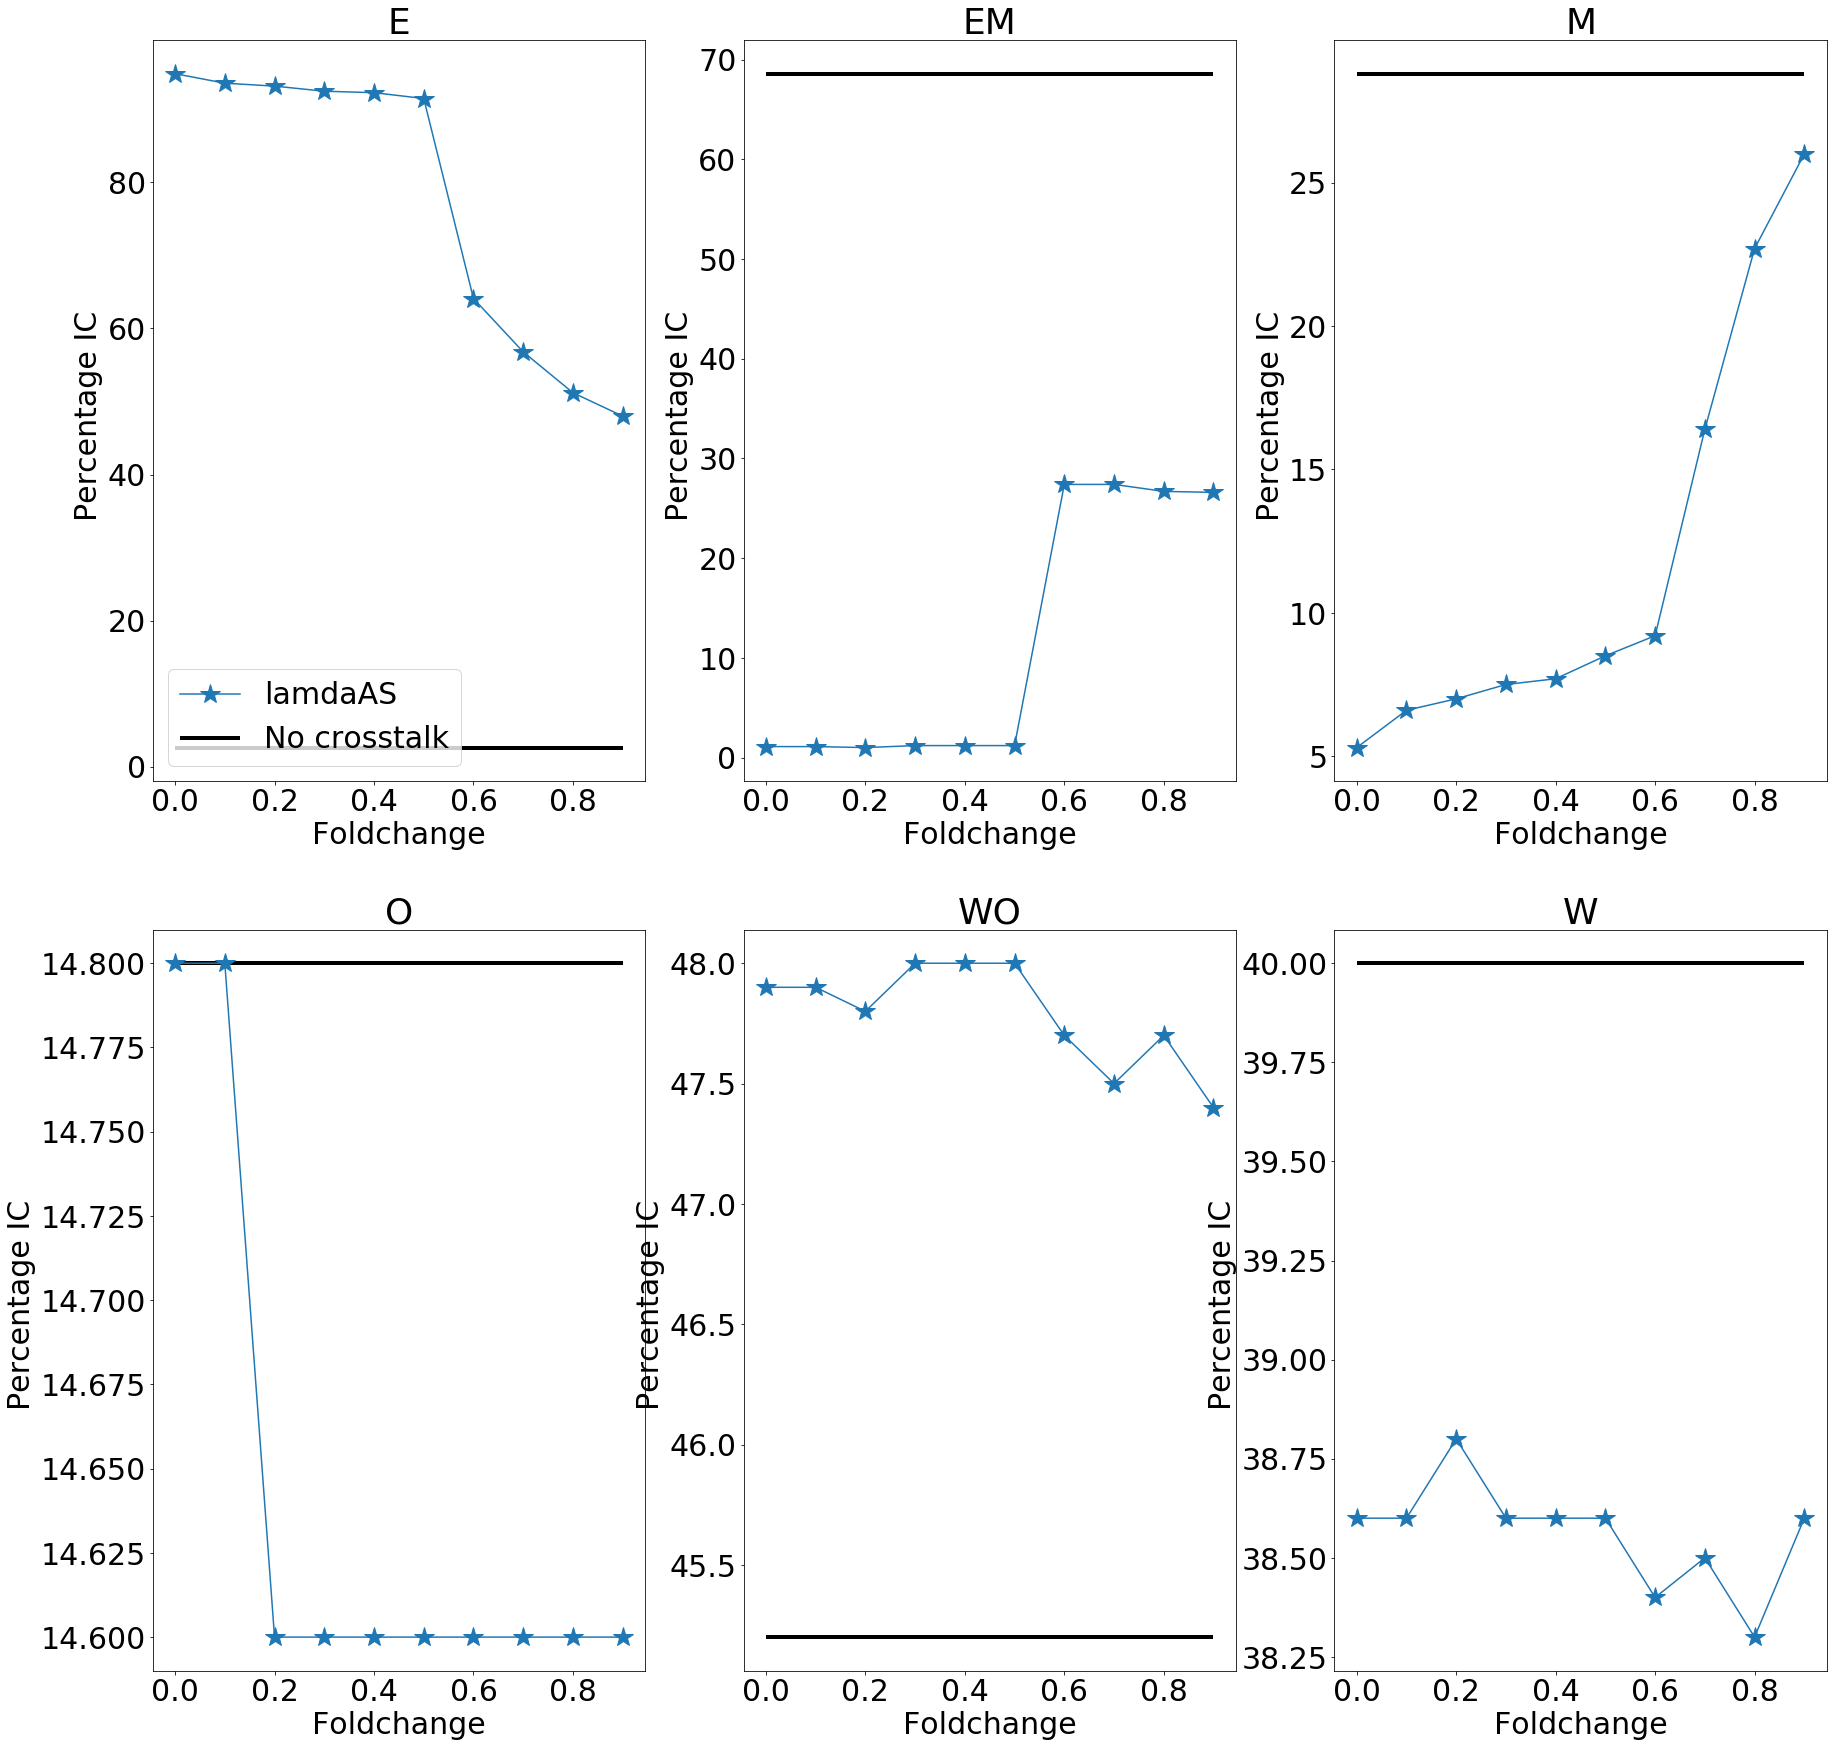

lamdaIHu


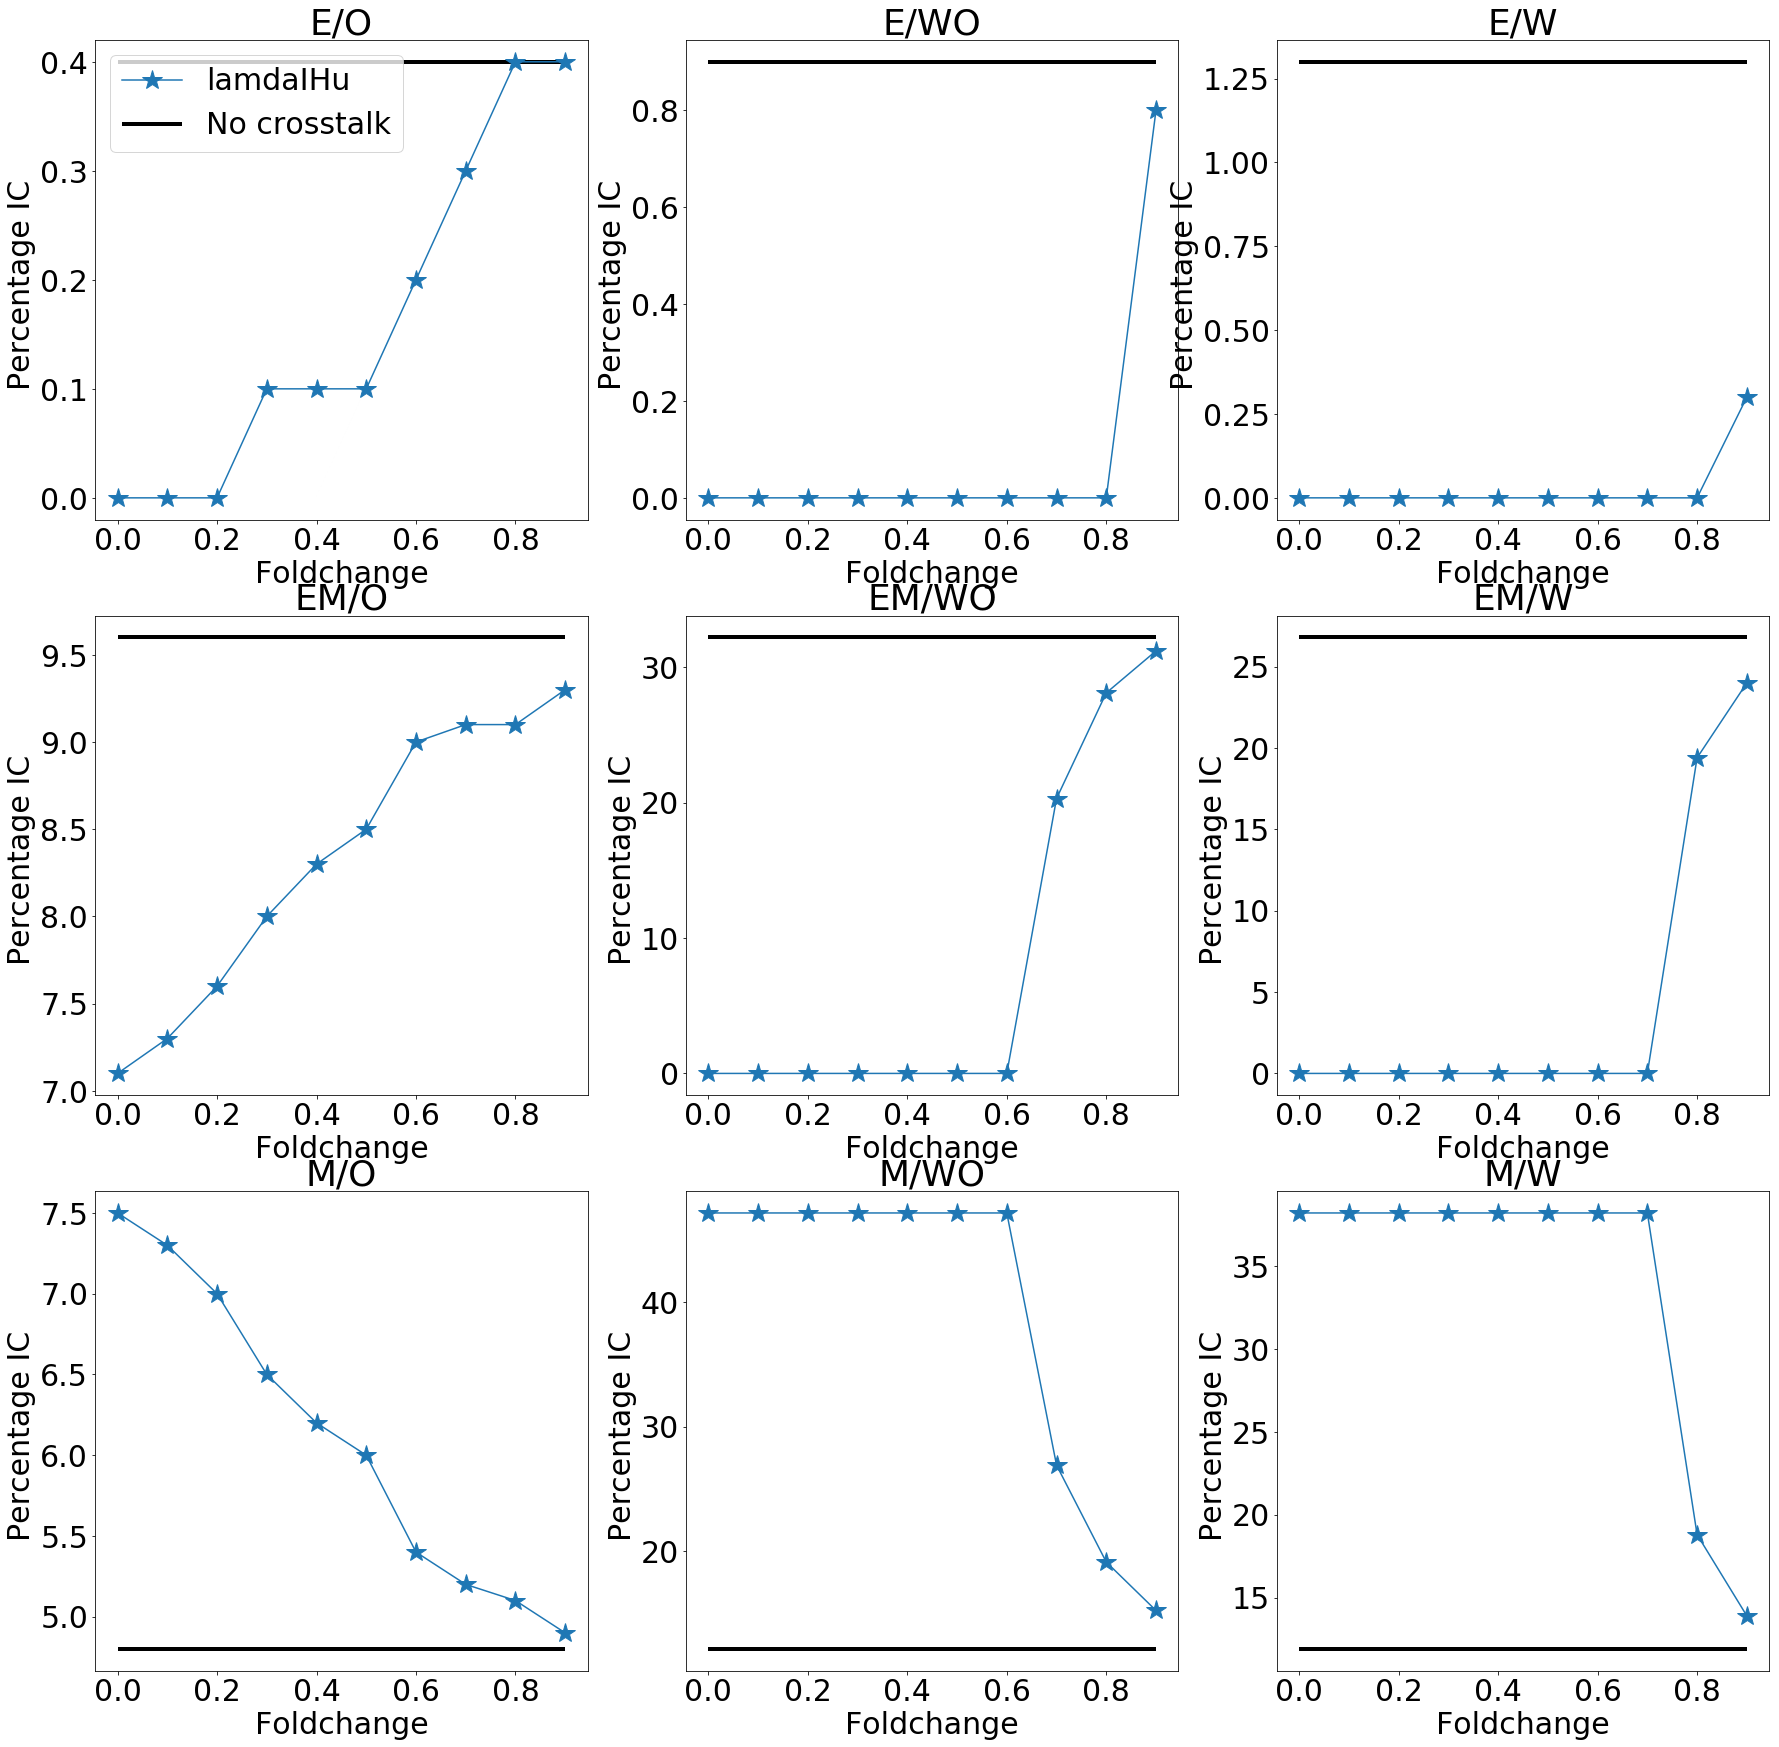

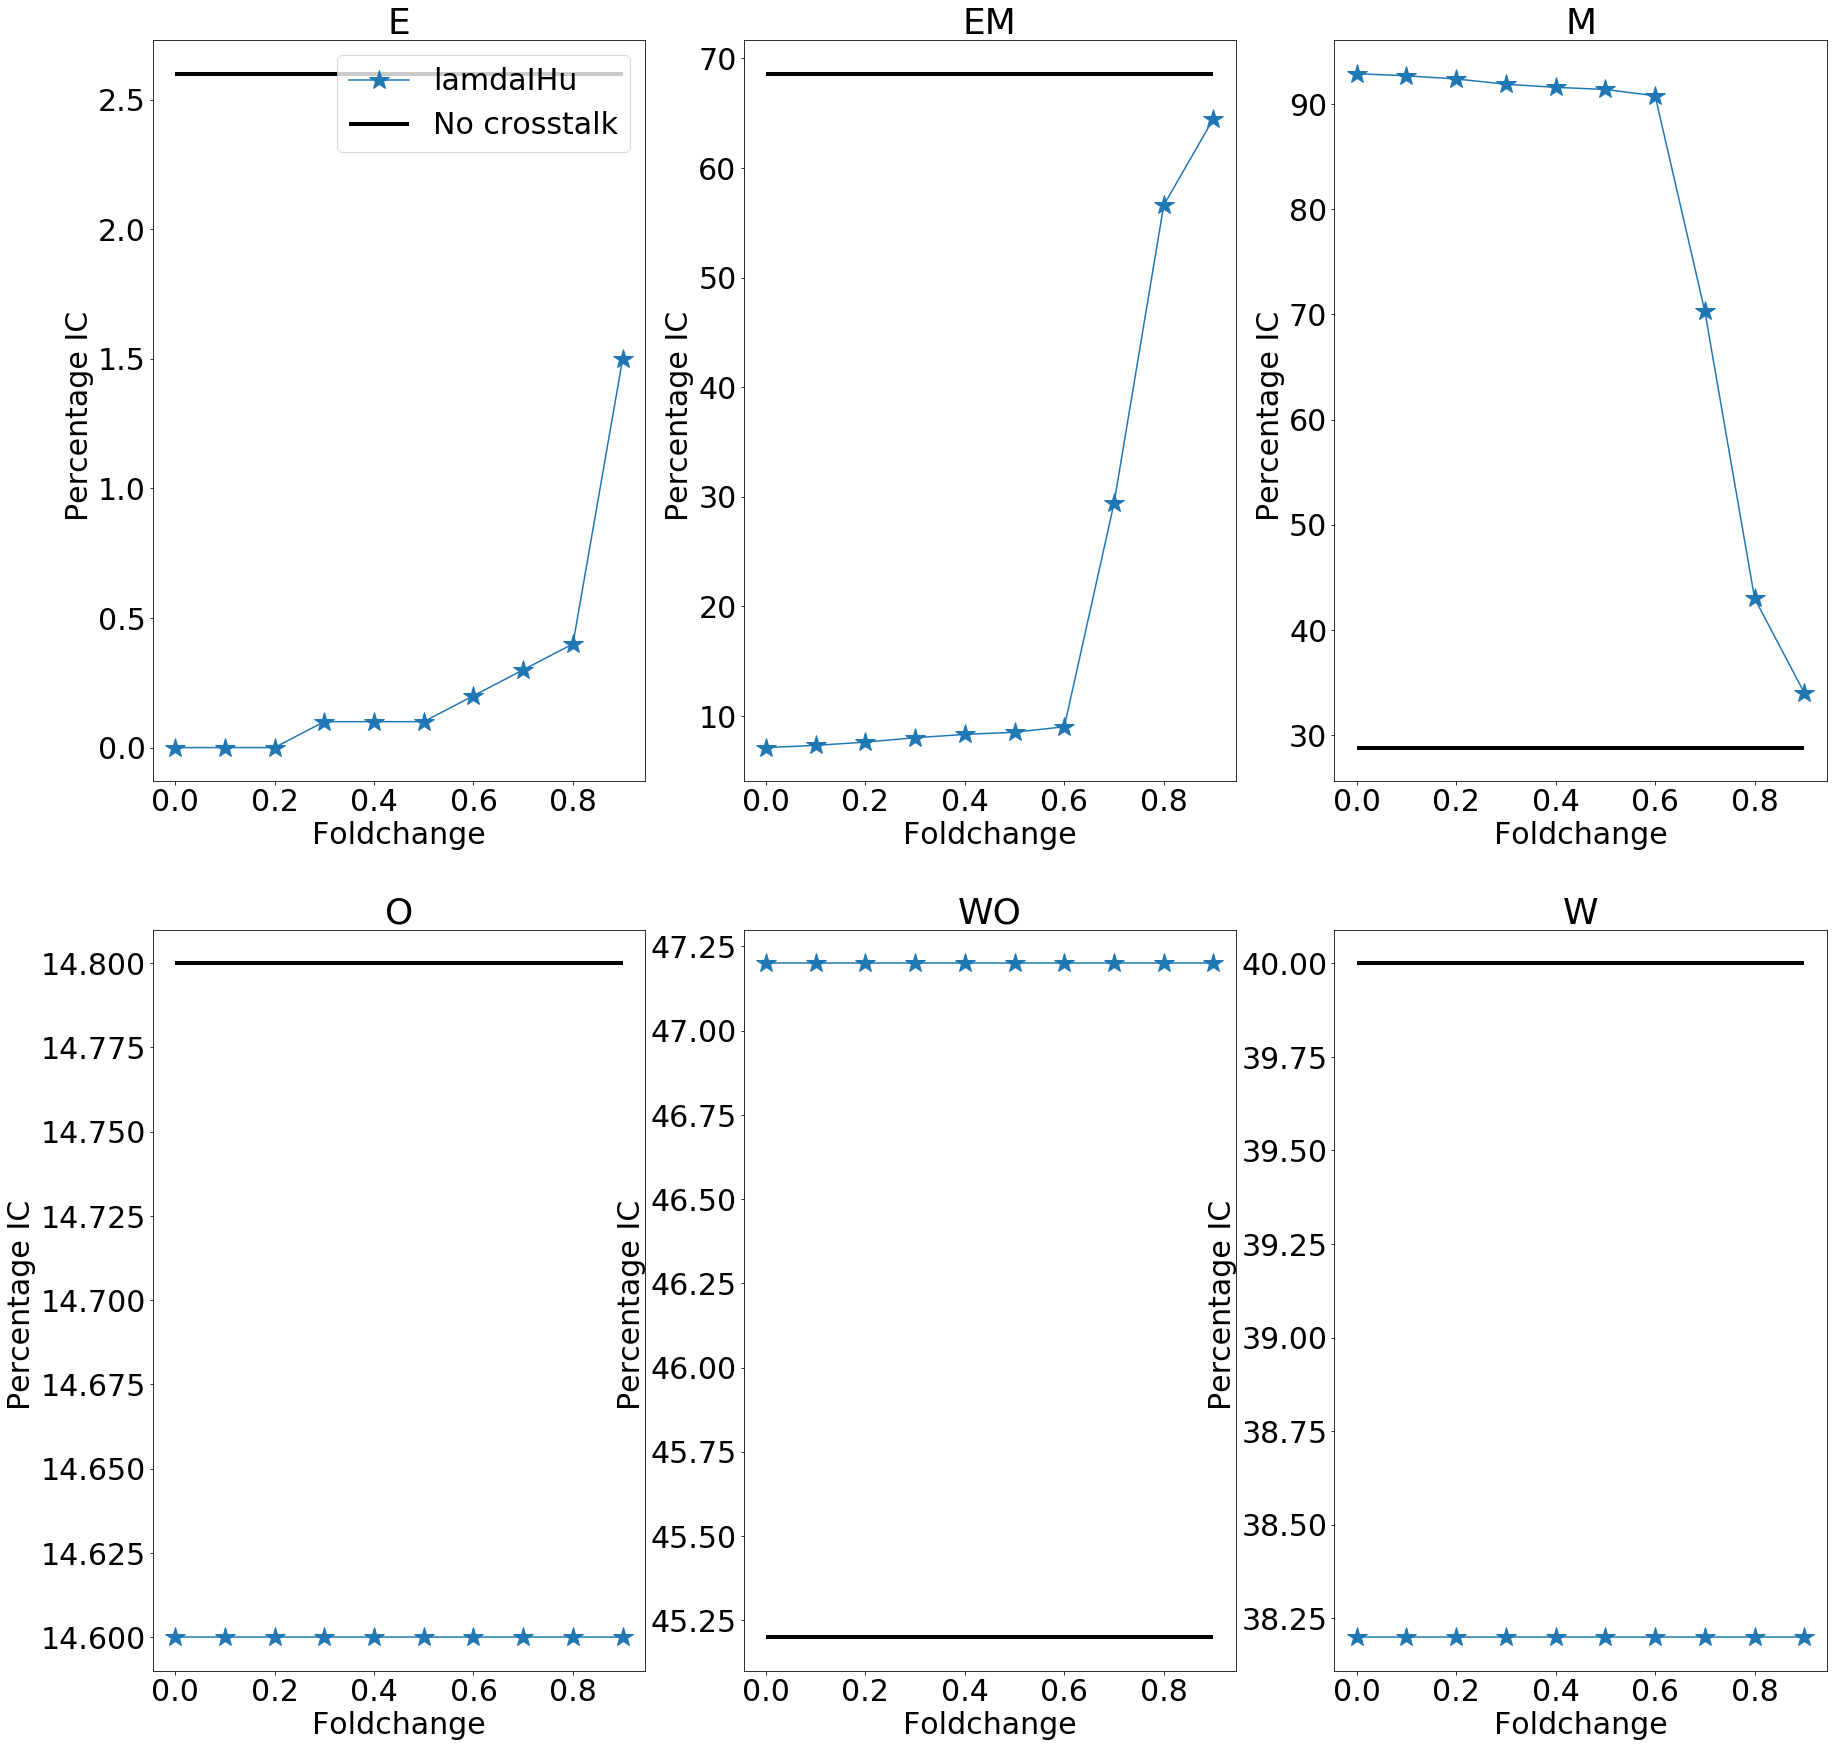

lamdaAu


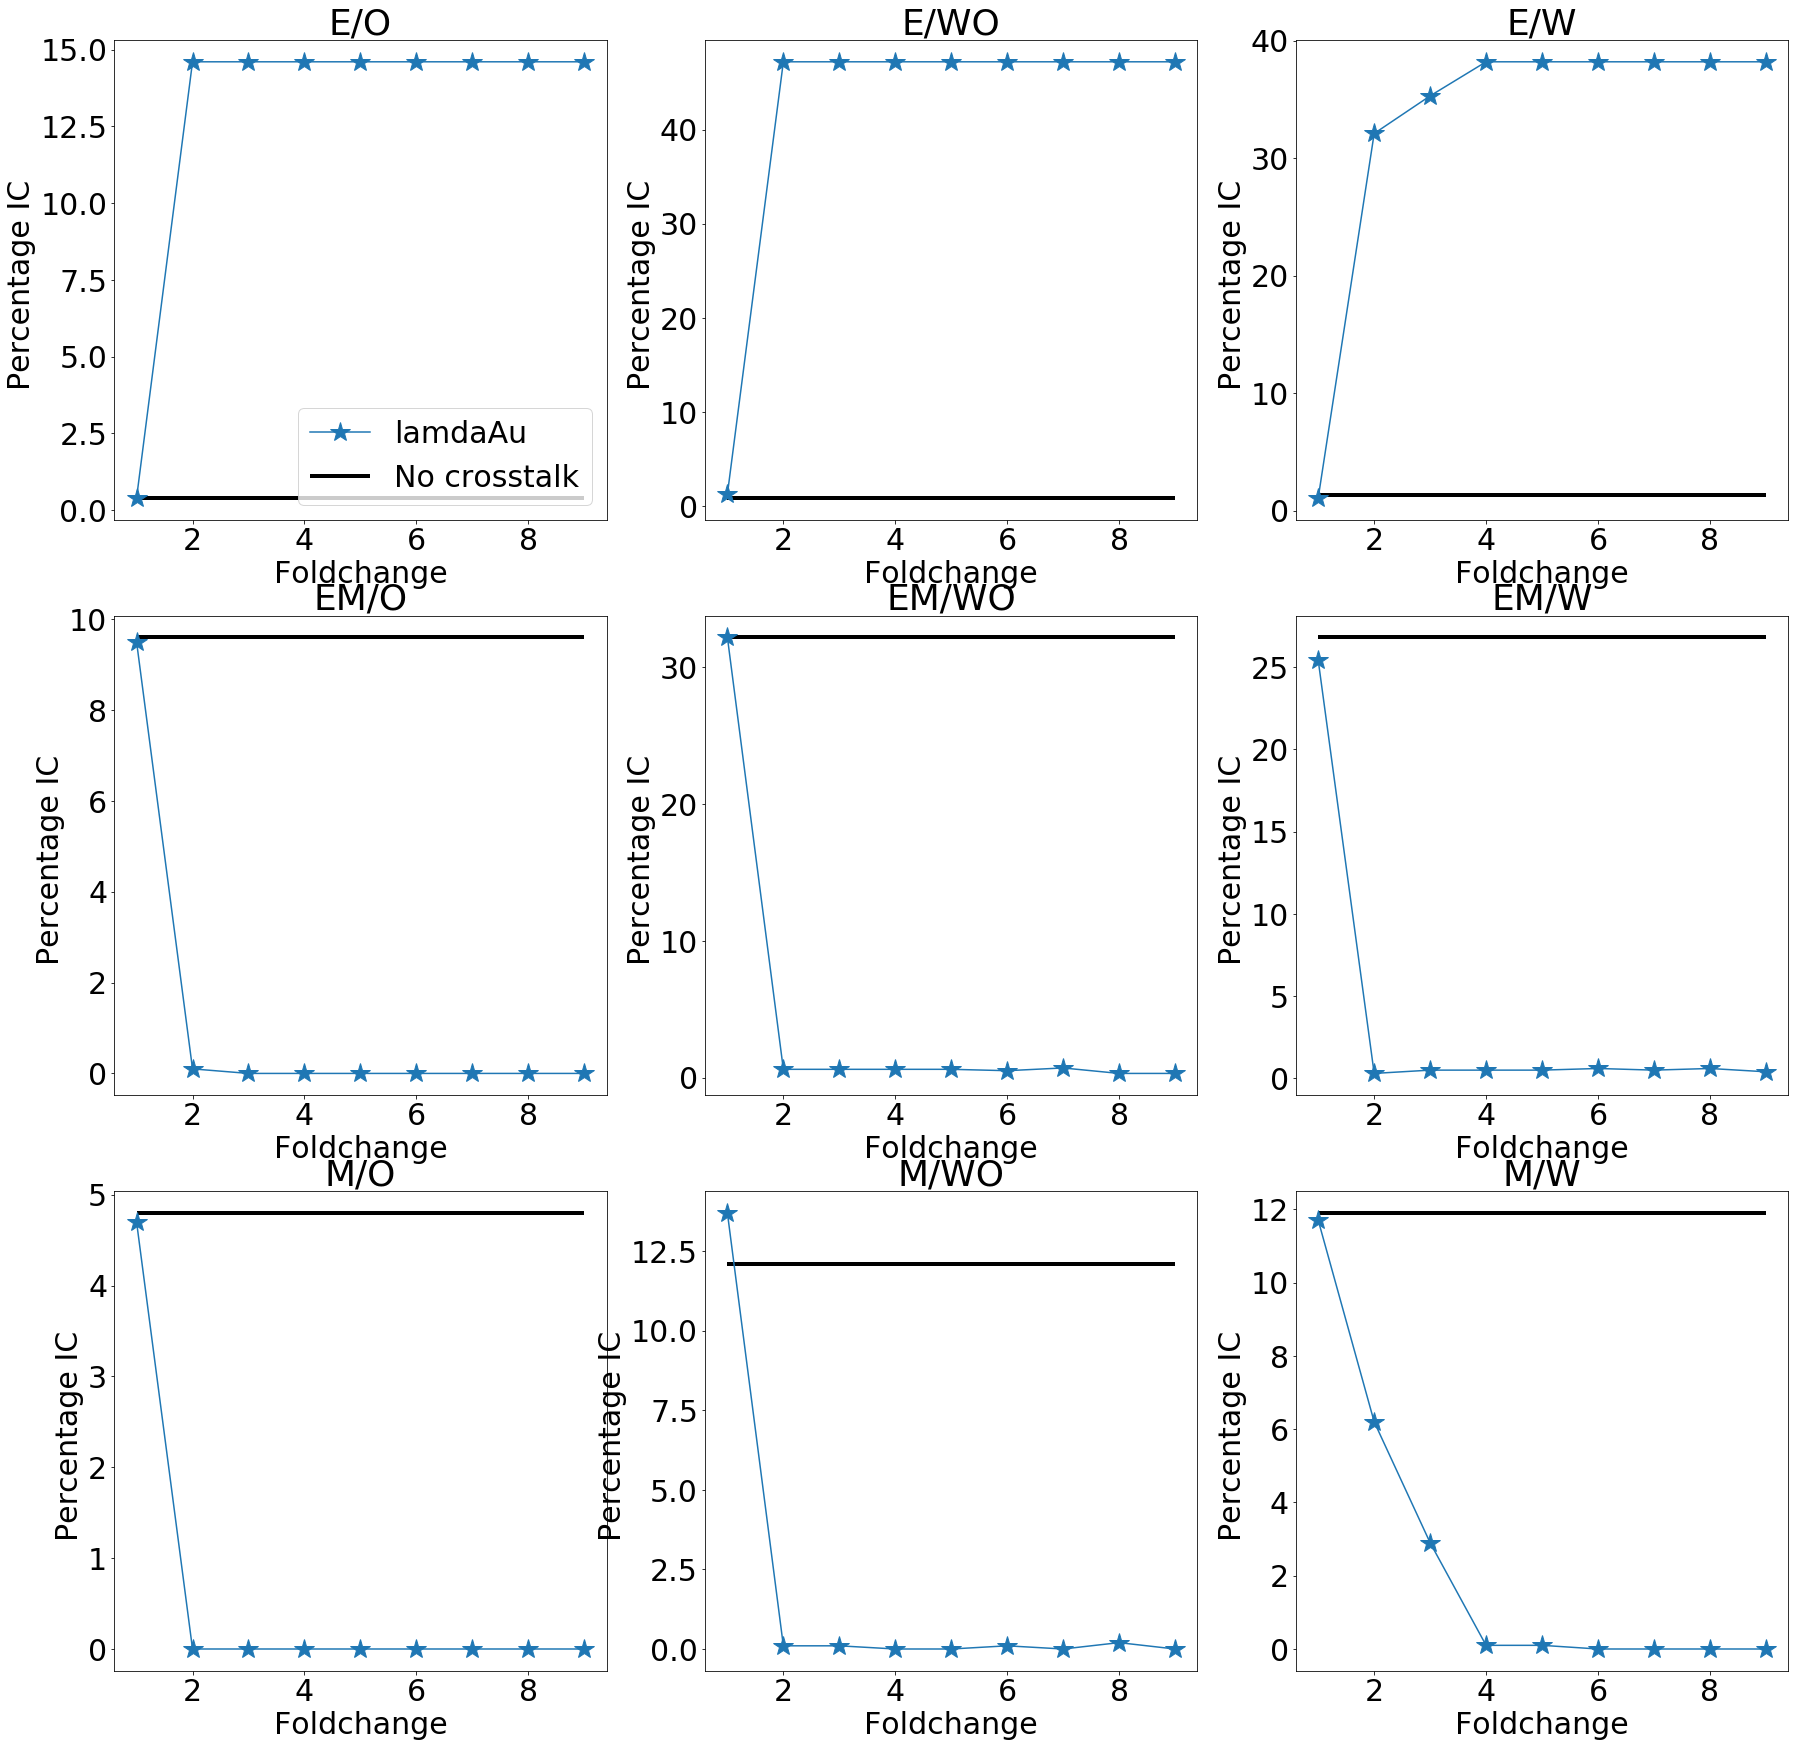

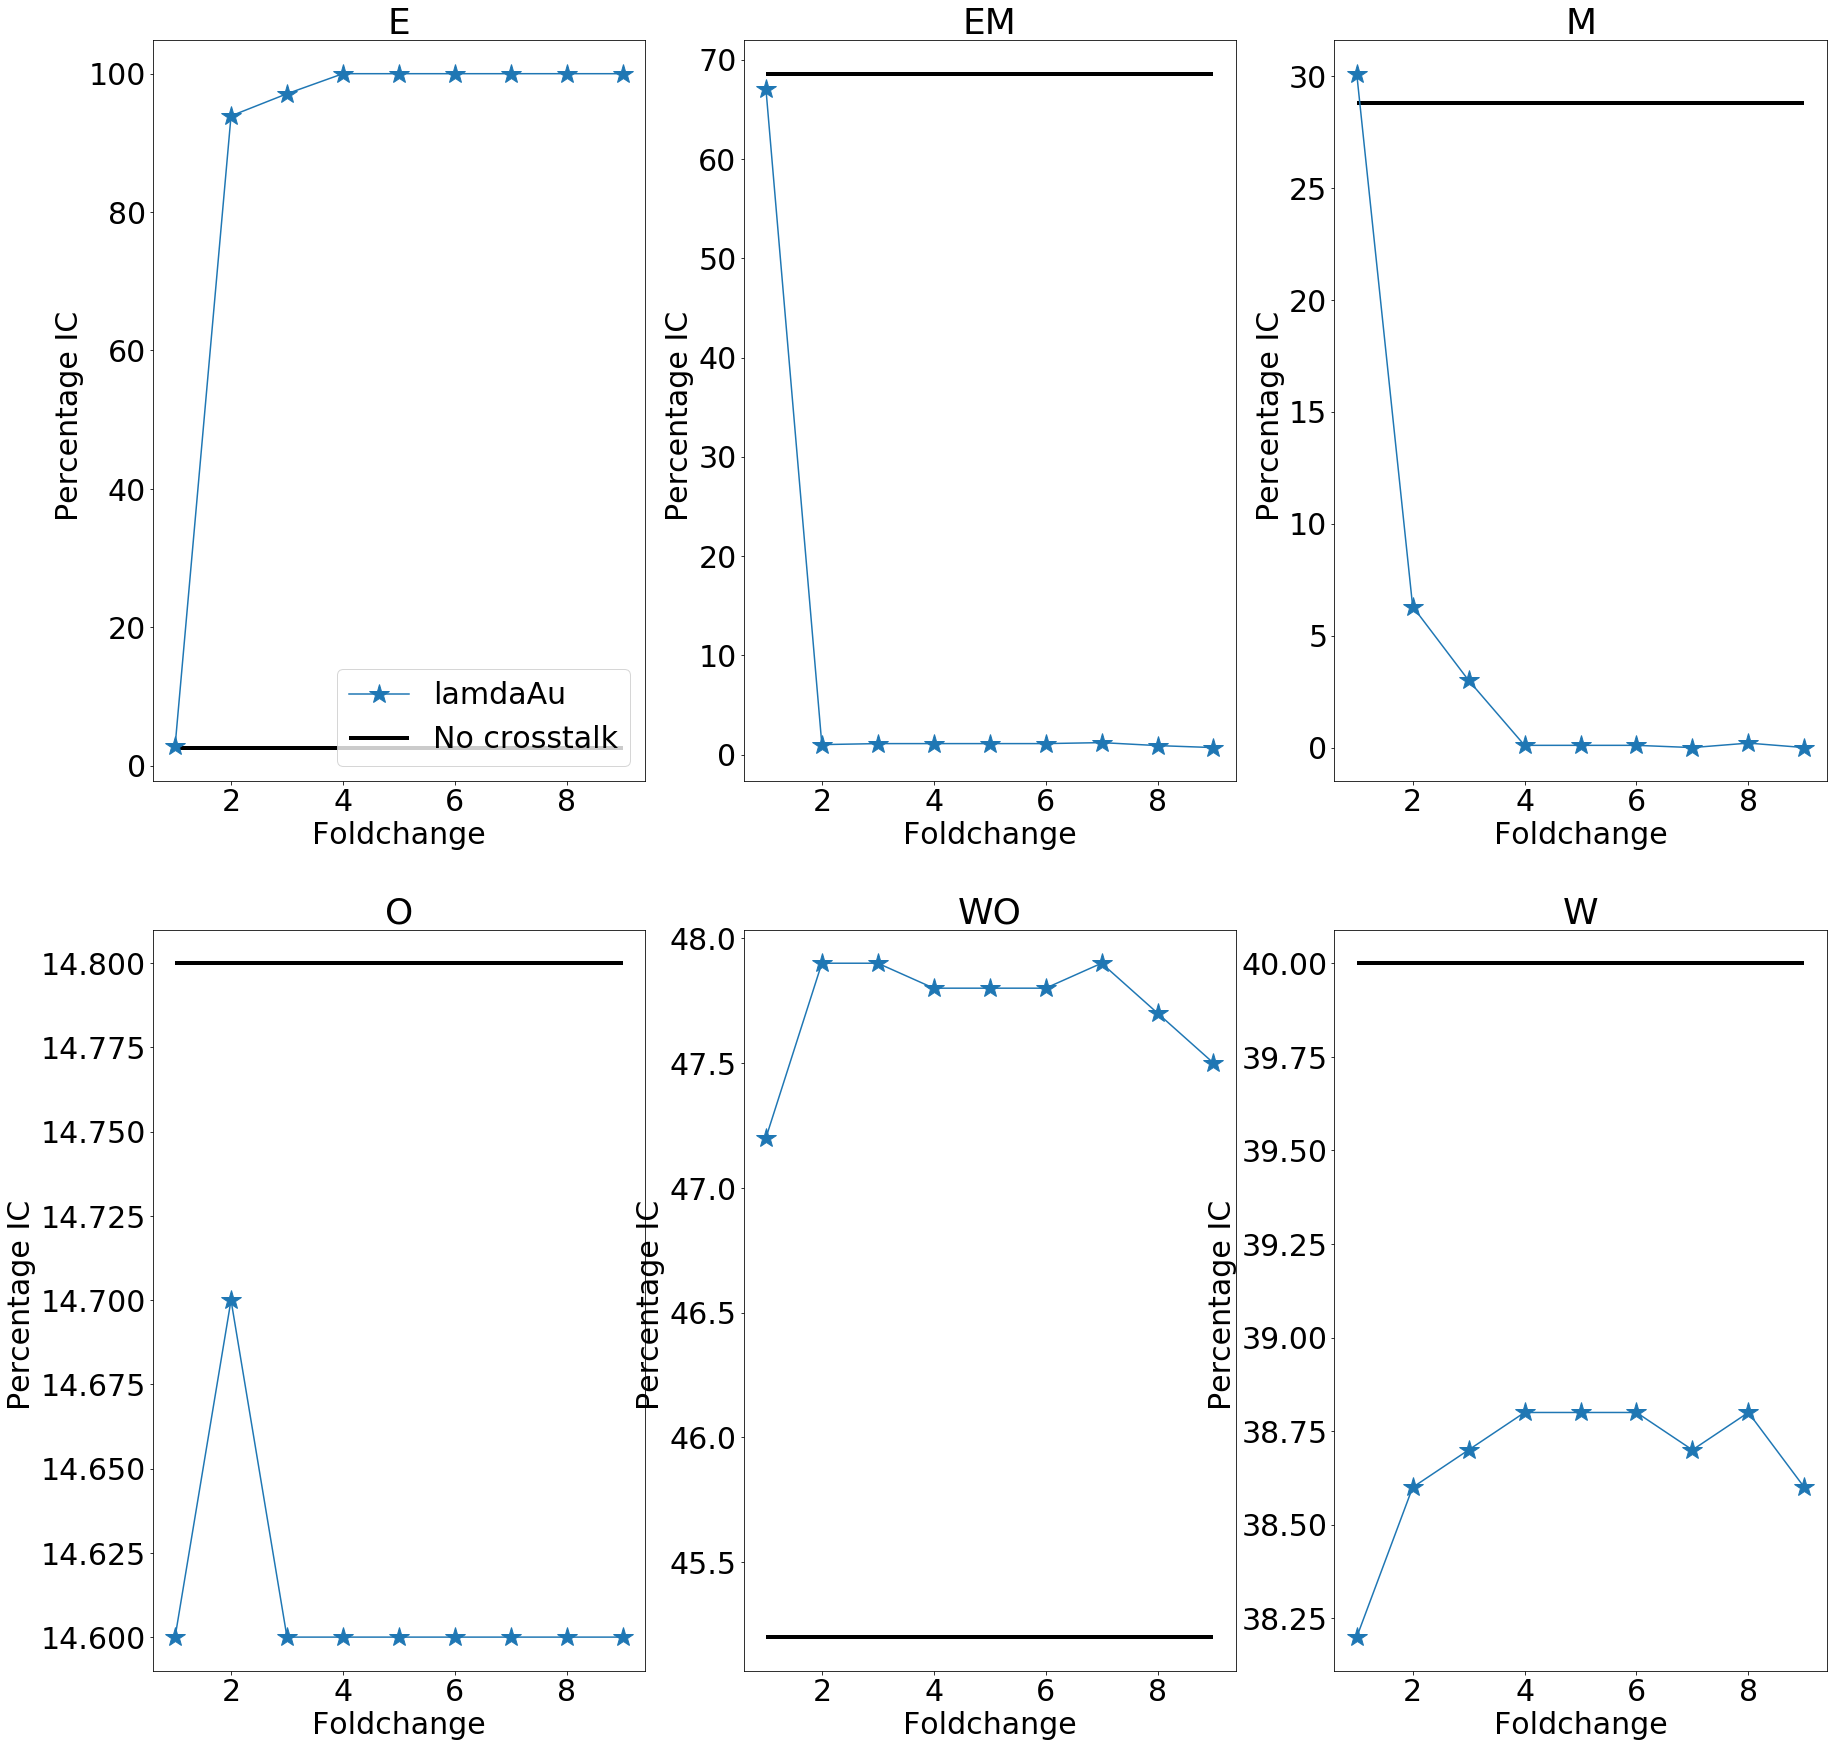

lamdaHu


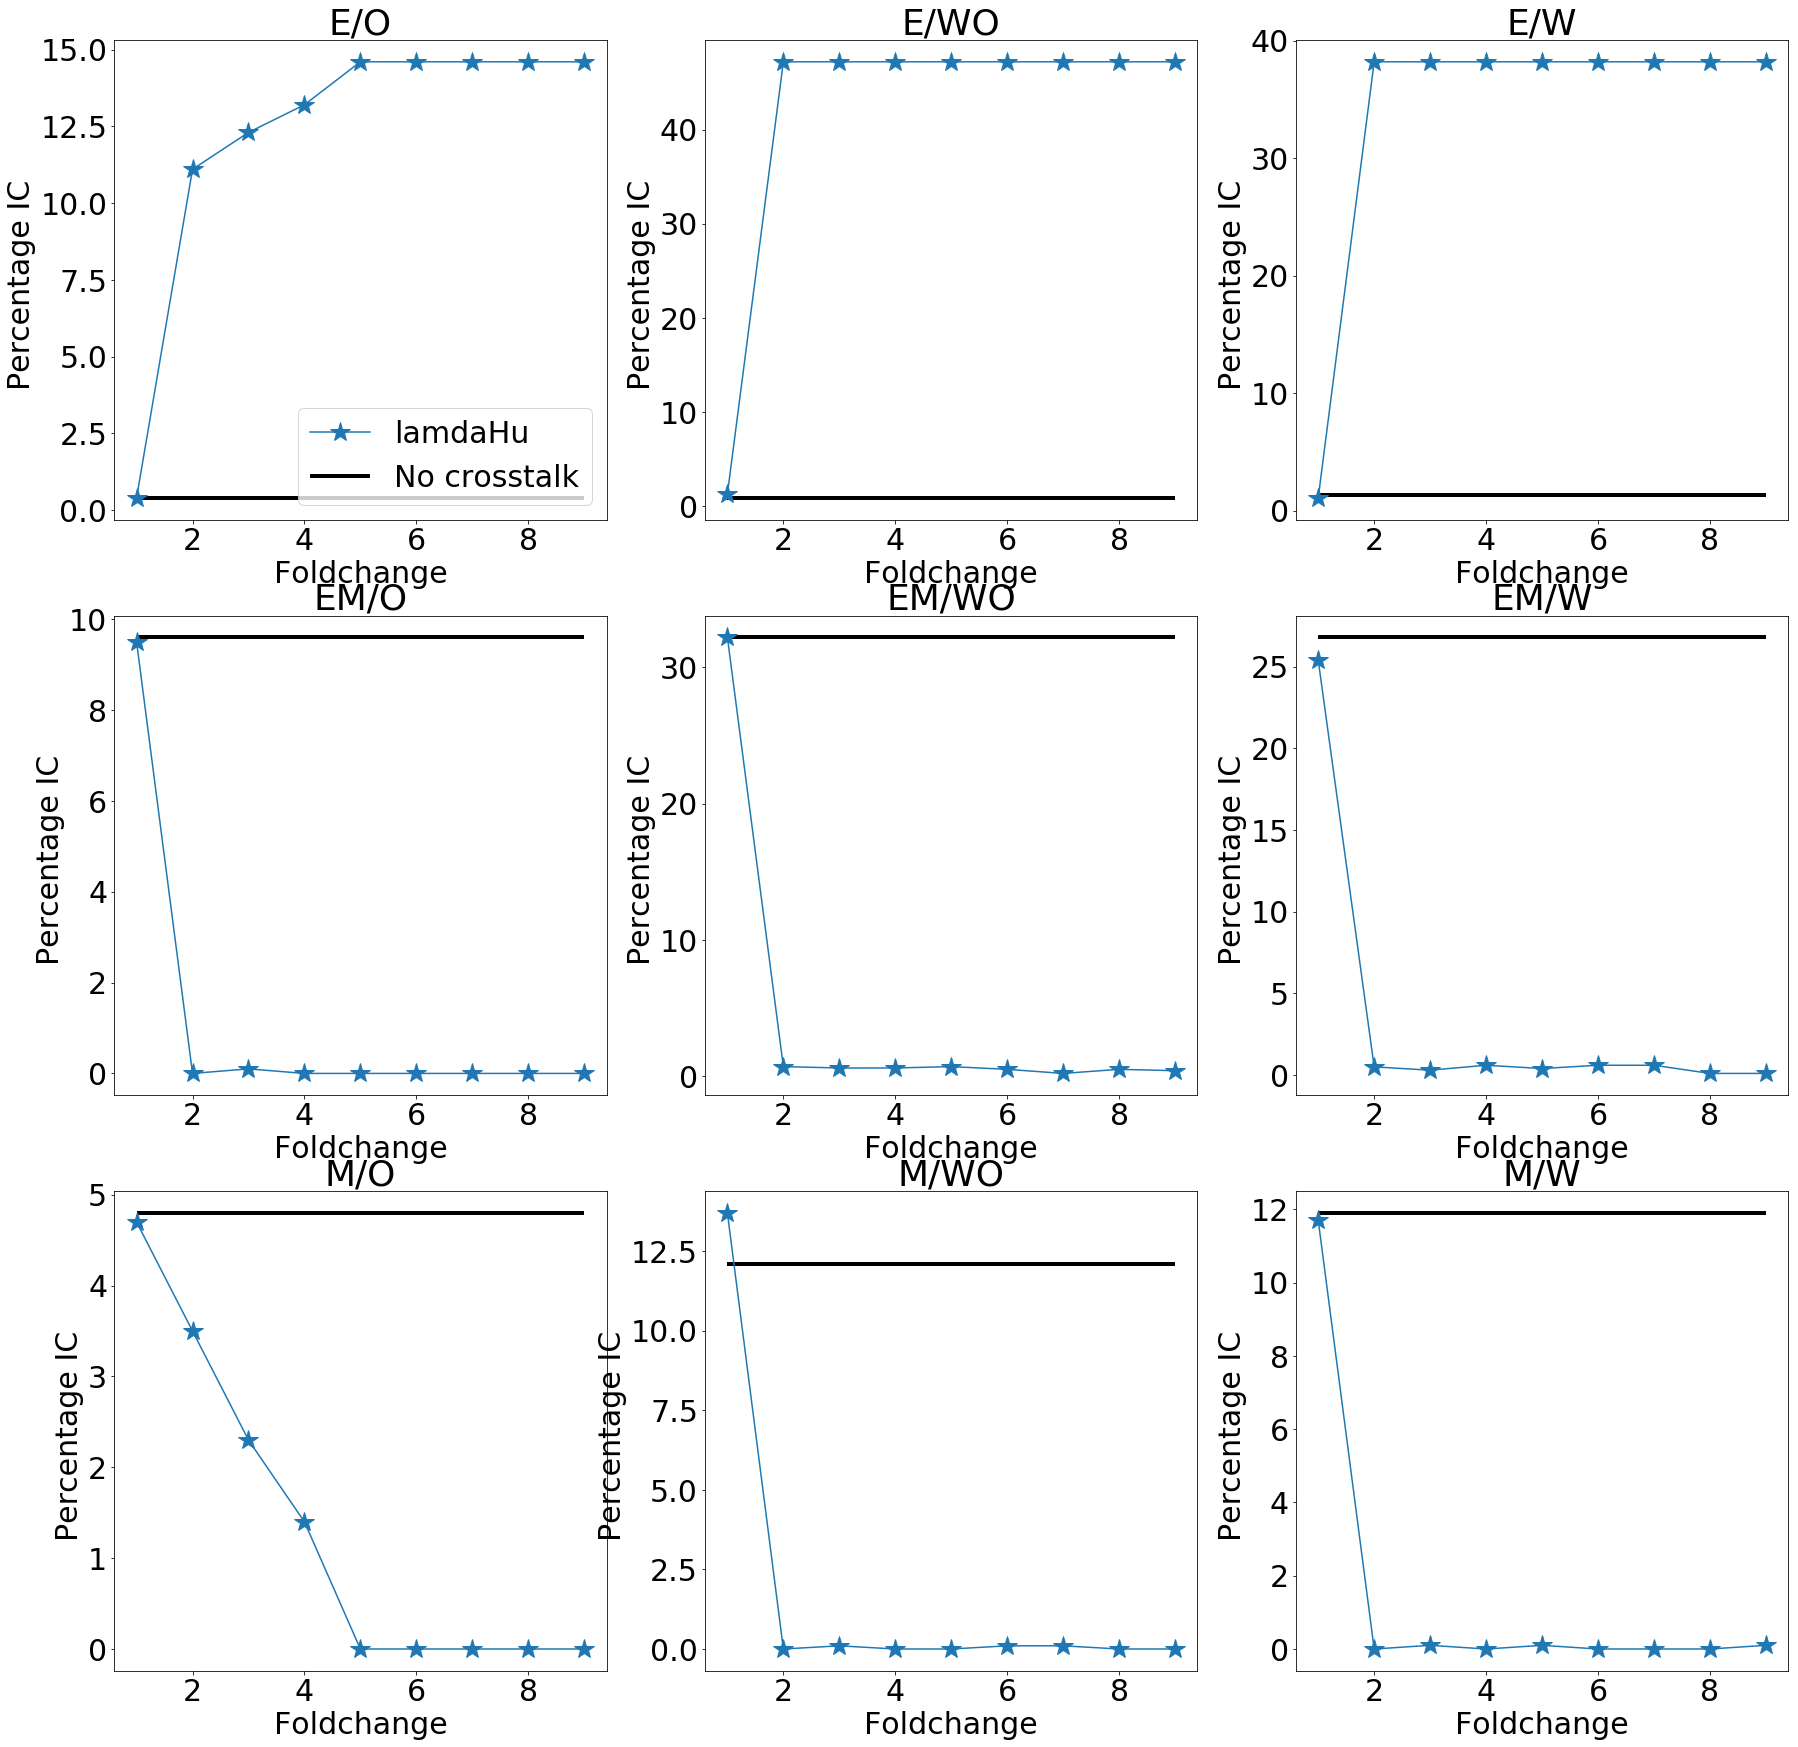

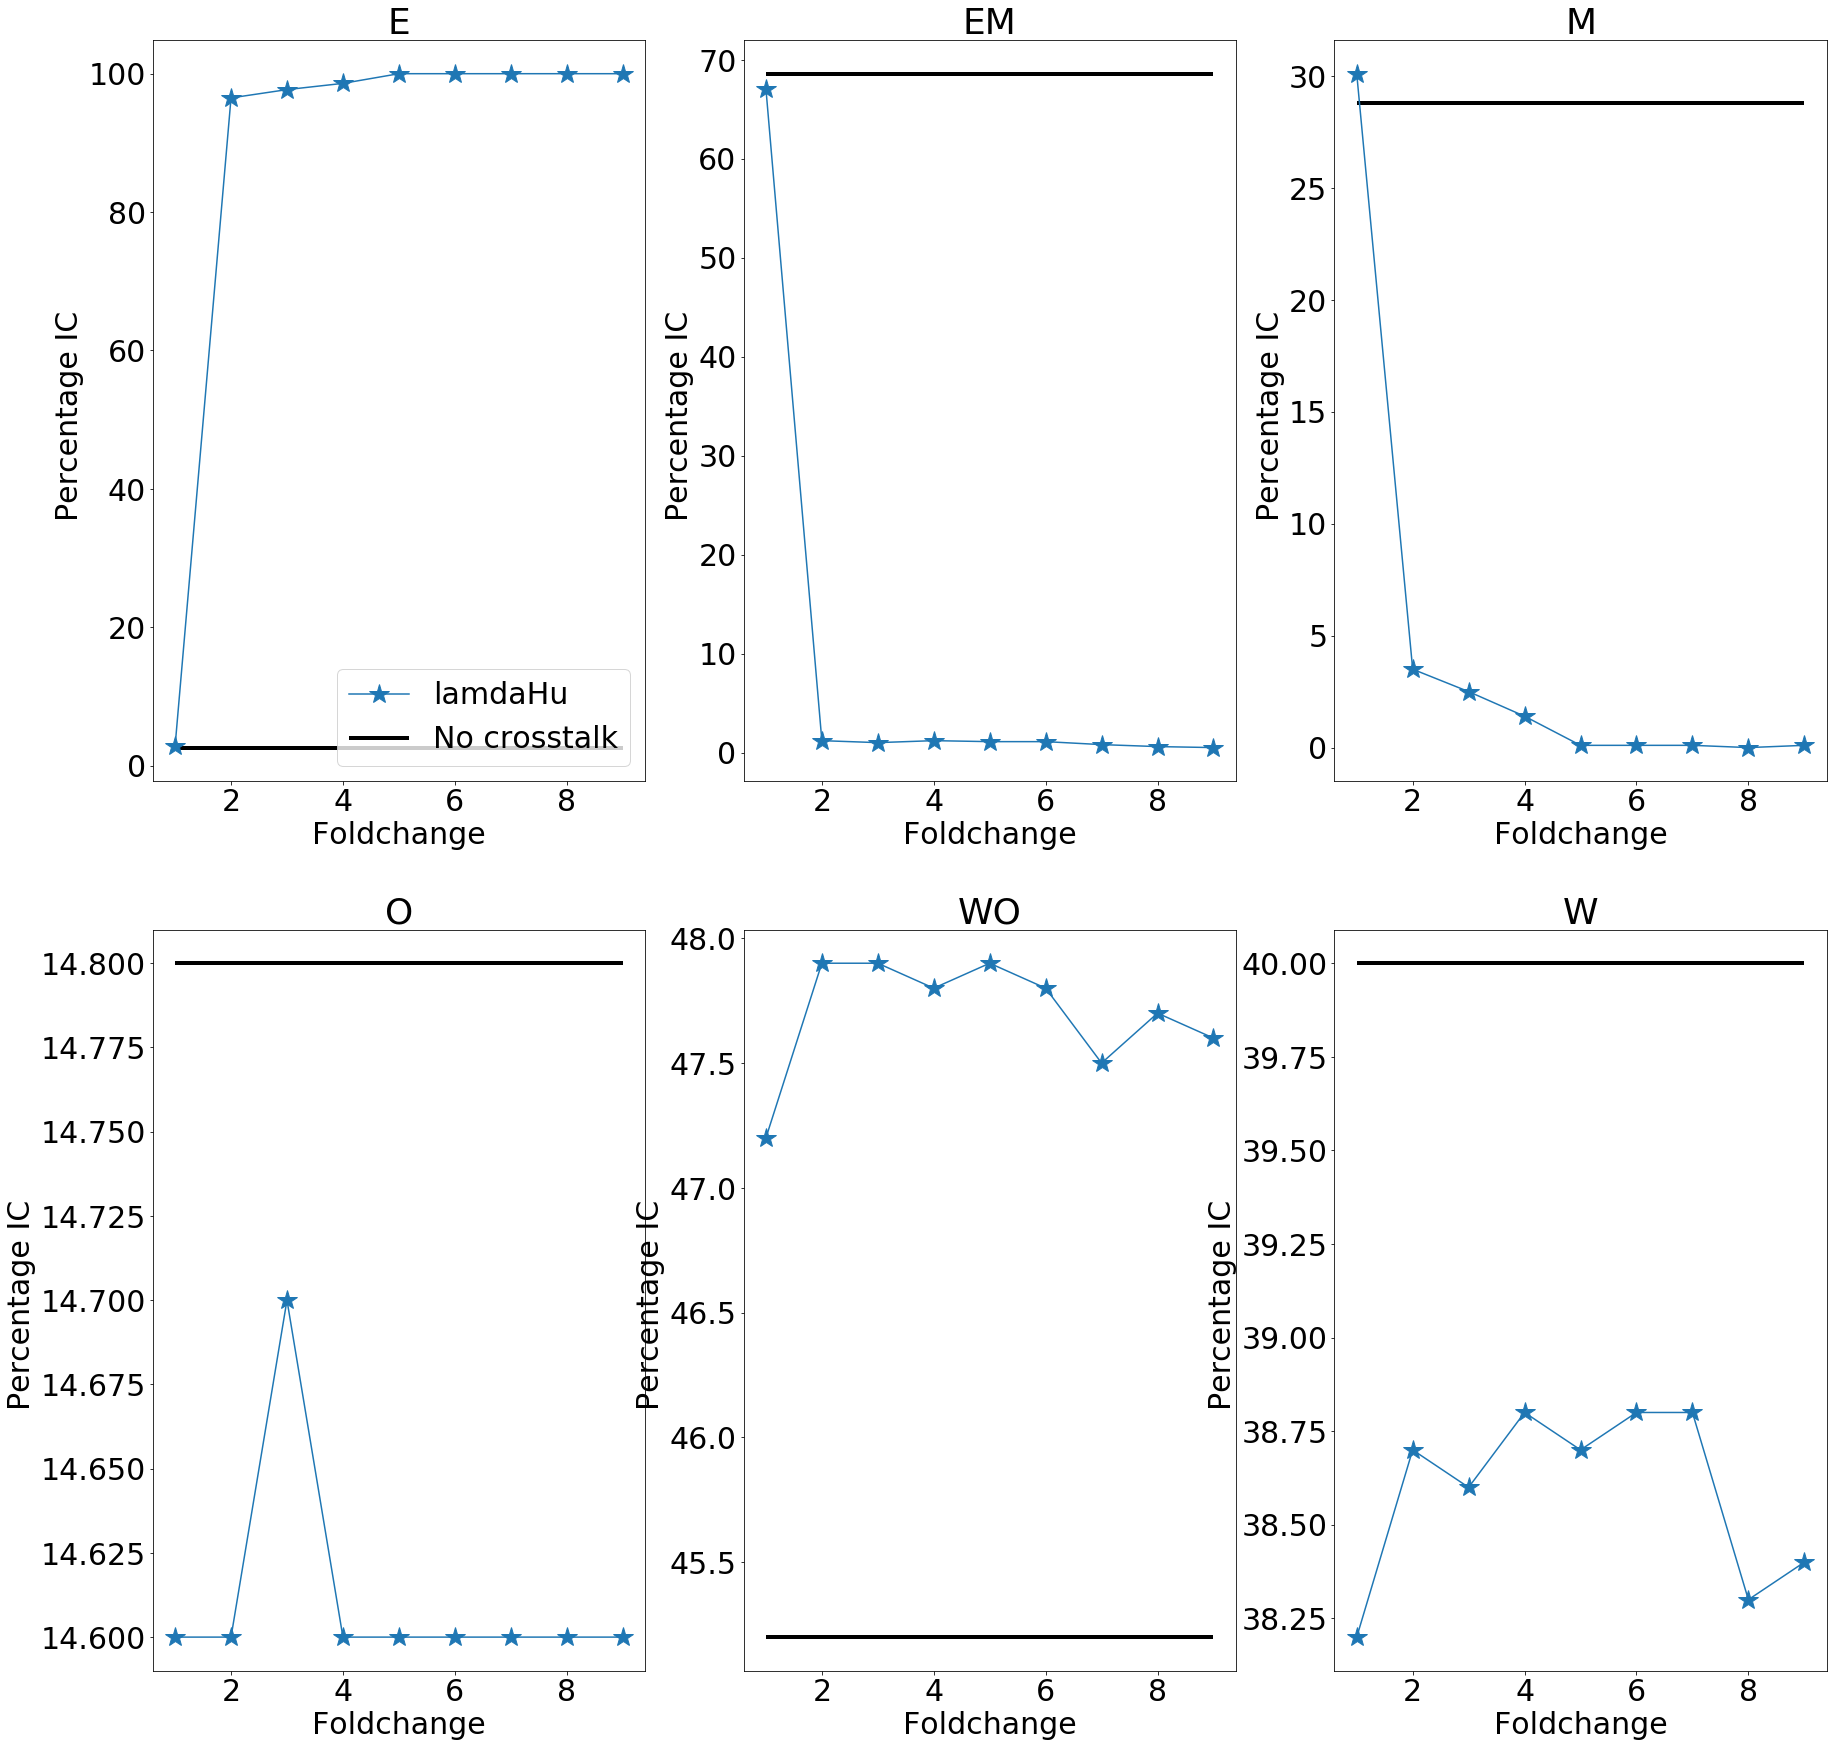

In [11]:
    plotFCSingleLink()

# Now to loops and Uh

In [12]:
def getFileSet(direct):
    regs={}
    for filen in os.listdir(direct):
        if "res.txt" in filen:
            #print filen
            #plotRes(direct+filen)
            name= filen.split(".")[0].split("_")[2]
            lamda=''
            while name[-1].isdigit():
                lamda=name[-1]+lamda
                name = name[:-1]

            if name not in regs.keys():
                regs[name]={}

            tmp = regs[name]
            for i in range(len(lamda)):
                if lamda[i] not in tmp.keys():
                    if i==len(lamda)-1:
                        tmp[lamda[i]]=[[lamda,filen]]
                    else:
                        tmp[lamda[i]]={}
                        tmp=tmp[lamda[i]]
                else:
                    tmp=tmp[lamda[i]]

            tmp =[]

    return regs

In [13]:
def getFileSet2(direct):
    lists={'x':[],'y':[],'c':[],'l':[]}
    count=0
    for filen in os.listdir(direct):
        if "res.txt" in filen:
            #print filen
            #plotRes(direct+filen)
            name= filen.split(".")[0].split("_")[2]
            lamda=''
            while name[-1].isdigit():
                lamda=name[-1]+lamda
                name = name[:-1]

            if ("AZ" in filen) or ("AS" in filen) or ("IHu" in filen)  :
                scale=0.1
            else:
                scale=1.
            lists['x']+=[count]
            lists['y']+=[filen]
            lists['c']+=[0]
            lists['l']+=[int(lamda)*scale]
            count+=1
    return lists

In [14]:
def printD(regs):
    name = regs.keys()[0]
    tmp =regs[name]
    while type(tmp) is dict:
        print tmp.keys()
        tmp = tmp[tmp.keys()[0]]

In [15]:
def printD_2(regs):
    lists={'x':[],'y':[],'c':[],'l':[]}
    name = regs.keys()[0]
    for x1 in regs[name]:
        for k2 in regs[name][x1]:
            lists['x']+=[int(x1)]
            lists['y']+=[regs[name][x1][k2][0][1]]
            lists['c']+=[int(k2)]
            lists['l']+=[int(k2)]
    return lists

In [16]:
def printD_m(regs):
    lists={'x':[],'y':[],'c':[],'l':[]}
    name = regs.keys()[0]
    for i in range(10):
        tmp =regs[name]
        while type(tmp) is dict:
            ii = np.random.randint(0,len(tmp.keys()))
            tmp = tmp[tmp.keys()[ii]]
        lists['x']+=[i]
        lists['y']+=[tmp[0][1] ]   
        lists['c']+=[0]
        lists['l']+=[int(tmp[0][0])]
    return lists

In [17]:
def plotLoops(dirc,results,xlab,title,legL,labelAll=False):
    
    ogFile="coupledWReg_Ccode/crosstalk_comparison/EMT_MR_comp_0_1000_res.txt"
    nics=1000.

    df_res =pd.read_csv(ogFile).dropna()
    nocross,noCs,tmp  =getStates_fromMap(df_res,hold=True)
    
    for i in range(len(results['y'])):
        
        try:
            df = pd.read_csv(dirc+results['y'][i]).dropna()
            mapResE,resSum,maxC =getStates_fromMap(df,hold=True)
            tmp={}
            for j in range(len(mapResE['name'])):
                tmp[mapResE['name'][j]]=mapResE['amount'][j]/nics*100.
            for j in range(len(resSum['name'])):
                tmp[resSum['name'][j]]=resSum['amount'][j]/nics*100.

            results['y'][i] = tmp
        except:
            results['y'][i]={'E':-100,'EM':-100,'M':-100,'O':-100,'WO':-100,'W':-100,'E/O':-100,'E/WO':-100,'E/W':-100,'EM/O':-100,'EM/WO':-100,'EM/W':-100,'M/O':-100,'M/WO':-100,'M/W':-100}

    mpl.rcParams['xtick.labelsize'] = 30
    mpl.rcParams['ytick.labelsize'] = 30
    mpl.rcParams.update({'font.size': 30})
        
   
    plotCoupledLoop(results,nocross,nics,xlab,title,legL,labelAll)
    plotStateSumLoop(results,noCs,nics,xlab,title,legL,labelAll)

In [18]:
def plotCoupledLoop(results,nocross,nics,xlab,title,legL,labelAll):
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(30,30))
    plt.subplots_adjust(hspace=0.3,right=0.85)
    
    my_cmap= cm.get_cmap('gist_rainbow')
    my_norm=Normalize(vmin=0,vmax=np.max(results['c']))
    markers=['s','D','*','o']
    for i in range(len(results['y'])):
        if results['x'][i]==2 and not labelAll:
            try:
                ax1.plot(results['x'][i],results['y'][i]['E/O'],marker=markers[results['c'][i]%len(markers)],markersize=20,label=legL+str(results['l'][i]),color=my_cmap(my_norm(results['c'][i])))
            except:
                ax1.plot(results['x'][i],results['y'][i]['E/O'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        else:
            ax1.plot(results['x'][i],results['y'][i]['E/O'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax2.plot(results['x'][i],results['y'][i]['E/WO'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax3.plot(results['x'][i],results['y'][i]['E/W'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax4.plot(results['x'][i],results['y'][i]['EM/O'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax5.plot(results['x'][i],results['y'][i]['EM/WO'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax6.plot(results['x'][i],results['y'][i]['EM/W'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax7.plot(results['x'][i],results['y'][i]['M/O'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax8.plot(results['x'][i],results['y'][i]['M/WO'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax9.plot(results['x'][i],results['y'][i]['M/W'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))

    if labelAll:
        ax1.set_xticks(results['x'])
        ax1.set_xticklabels(results['l'],rotation=30)
        ax2.set_xticks(results['x'])
        ax2.set_xticklabels(results['l'],rotation=30)
        ax3.set_xticks(results['x'])
        ax3.set_xticklabels(results['l'],rotation=30)
        ax4.set_xticks(results['x'])
        ax4.set_xticklabels(results['l'],rotation=30)
        ax5.set_xticks(results['x'])
        ax5.set_xticklabels(results['l'],rotation=30)
        ax6.set_xticks(results['x'])
        ax6.set_xticklabels(results['l'],rotation=30)
        ax7.set_xticks(results['x'])
        ax7.set_xticklabels(results['l'],rotation=30)
        ax8.set_xticks(results['x'])
        ax8.set_xticklabels(results['l'],rotation=30)
        ax9.set_xticks(results['x'])
        ax9.set_xticklabels(results['l'],rotation=30)
    else:
        set1 = ax1.get_xticks()
        ax1.set_xticklabels(set1,rotation=30)
        set2 = ax2.get_xticks()
        ax2.set_xticklabels(set2,rotation=30)
        set3 = ax3.get_xticks()
        ax3.set_xticklabels(set3,rotation=30)
        set4 = ax4.get_xticks()
        ax4.set_xticklabels(set4,rotation=30)
        set5 = ax5.get_xticks()
        ax5.set_xticklabels(set5,rotation=30)
        set6 = ax6.get_xticks()
        ax6.set_xticklabels(set6,rotation=30)
        set7 = ax7.get_xticks()
        ax7.set_xticklabels(set7,rotation=30)
        set8 = ax8.get_xticks()
        ax8.set_xticklabels(set8,rotation=30)
        set9 = ax9.get_xticks()
        ax9.set_xticklabels(set9,rotation=30)
    
    nocross['name']=np.array(nocross['name'])
    ind0 = np.argwhere(nocross['name']=='E/O')[:,0][0]
    ind1 = np.argwhere(nocross['name']=='E/WO')[:,0][0]
    ind2 = np.argwhere(nocross['name']=='E/W')[:,0][0]
    ind3 = np.argwhere(nocross['name']=='EM/O')[:,0][0]
    ind4 = np.argwhere(nocross['name']=='EM/WO')[:,0][0]
    ind5 = np.argwhere(nocross['name']=='EM/W')[:,0][0]
    ind6 = np.argwhere(nocross['name']=='M/O')[:,0][0]
    ind7 = np.argwhere(nocross['name']=='M/WO')[:,0][0]
    ind8 = np.argwhere(nocross['name']=='M/W')[:,0][0]
    ax1.hlines(nocross['amount'][ind0]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)#,label='No crosstalk')
    ax2.hlines(nocross['amount'][ind1]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax3.hlines(nocross['amount'][ind2]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax4.hlines(nocross['amount'][ind3]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax5.hlines(nocross['amount'][ind4]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax6.hlines(nocross['amount'][ind5]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax7.hlines(nocross['amount'][ind6]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax8.hlines(nocross['amount'][ind7]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax9.hlines(nocross['amount'][ind8]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax1.set_xlabel(xlab)#"Steady state")
    ax2.set_xlabel(xlab)#"Steady state")
    ax3.set_xlabel(xlab)#"Steady state")
    ax4.set_xlabel(xlab)#"Steady state")
    ax5.set_xlabel(xlab)#"Steady state")
    ax6.set_xlabel(xlab)#"Steady state")
    ax7.set_xlabel(xlab)#"Steady state")
    ax8.set_xlabel(xlab)#"Steady state")
    ax9.set_xlabel(xlab)#"Steady state")
    ax1.set_ylabel("Percentage IC ")
    ax2.set_ylabel("Percentage IC ")
    ax3.set_ylabel("Percentage IC ")
    ax4.set_ylabel("Percentage IC ")
    ax5.set_ylabel("Percentage IC ")
    ax6.set_ylabel("Percentage IC ")
    ax7.set_ylabel("Percentage IC ")
    ax8.set_ylabel("Percentage IC ")
    ax9.set_ylabel("Percentage IC ")
    ax1.set_title("E/O")
    ax2.set_title("E/WO")
    ax3.set_title("E/W")
    ax4.set_title("EM/O")
    ax5.set_title("EM/WO")
    ax6.set_title("EM/W")
    ax7.set_title("M/O")
    ax8.set_title("M/WO")
    ax9.set_title("M/W")

    if not labelAll:
        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles,labels=labels,loc="center right",borderaxespad=0.1,title="Legend")
    fig.savefig(title+"_coupledStates.png",bbox_inches='tight')
    #plt.show()
    plt.close()

In [19]:
def plotStateSumLoop(results,nocross,nics,xlab,title,legL,labelAll):
    fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(30,20))
    plt.subplots_adjust(hspace=0.3,right=0.85)
    markers=['s','D','*','o']
    my_cmap= cm.get_cmap('gist_rainbow')
    my_norm=Normalize(vmin=0,vmax=np.max(results['c']))
    for i in range(len(results['y'])):
        if results['x'][i]==2 and not labelAll:
            try:
                ax1.plot(results['x'][i],results['y'][i]['E'],marker=markers[results['c'][i]%len(markers)],markersize=20,label=legL+str(results['l'][i]),color=my_cmap(my_norm(results['c'][i])))
            except:
                ax1.plot(results['x'][i],results['y'][i]['E'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        else:
            ax1.plot(results['x'][i],results['y'][i]['E'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax2.plot(results['x'][i],results['y'][i]['EM'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax3.plot(results['x'][i],results['y'][i]['M'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax4.plot(results['x'][i],results['y'][i]['O'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax5.plot(results['x'][i],results['y'][i]['WO'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))
        ax6.plot(results['x'][i],results['y'][i]['W'],marker=markers[results['c'][i]%len(markers)],markersize=20,color=my_cmap(my_norm(results['c'][i])))


    if labelAll:
        ax1.set_xticks(results['x'])
        ax1.set_xticklabels(results['l'],rotation=30)
        ax2.set_xticks(results['x'])
        ax2.set_xticklabels(results['l'],rotation=30)
        ax3.set_xticks(results['x'])
        ax3.set_xticklabels(results['l'],rotation=30)
        ax4.set_xticks(results['x'])
        ax4.set_xticklabels(results['l'],rotation=30)
        ax5.set_xticks(results['x'])
        ax5.set_xticklabels(results['l'],rotation=30)
        ax6.set_xticks(results['x'])
        ax6.set_xticklabels(results['l'],rotation=30)
    else:
        set1 = ax1.get_xticks()
        ax1.set_xticklabels(set1,rotation=30)
        set2 = ax2.get_xticks()
        ax2.set_xticklabels(set2,rotation=30)
        set3 = ax3.get_xticks()
        ax3.set_xticklabels(set3,rotation=30)
        set4 = ax4.get_xticks()
        ax4.set_xticklabels(set4,rotation=30)
        set5 = ax5.get_xticks()
        ax5.set_xticklabels(set5,rotation=30)
        set6 = ax6.get_xticks()
        ax6.set_xticklabels(set6,rotation=30)
    
    nocross['name']=np.array(nocross['name'])
    ind0 = np.argwhere(nocross['name']=='E')[:,0][0]
    ind1 = np.argwhere(nocross['name']=='EM')[:,0][0]
    ind2 = np.argwhere(nocross['name']=='M')[:,0][0]
    ind3 = np.argwhere(nocross['name']=='O')[:,0][0]
    ind4 = np.argwhere(nocross['name']=='WO')[:,0][0]
    ind5 = np.argwhere(nocross['name']=='W')[:,0][0]
    ax1.hlines(nocross['amount'][ind0]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)#,label='No crosstalk')
    ax2.hlines(nocross['amount'][ind1]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax3.hlines(nocross['amount'][ind2]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax4.hlines(nocross['amount'][ind3]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax5.hlines(nocross['amount'][ind4]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax6.hlines(nocross['amount'][ind5]/nics*100.,xmin=np.min(results['x']),xmax=np.max(results['x']),linewidth=4)
    ax1.set_xlabel(xlab)#"Steady state")
    ax2.set_xlabel(xlab)#"Steady state")
    ax3.set_xlabel(xlab)#"Steady state")
    ax4.set_xlabel(xlab)#"Steady state")
    ax5.set_xlabel(xlab)#"Steady state")
    ax6.set_xlabel(xlab)#"Steady state")
    ax1.set_ylabel("Percentage IC ")
    ax2.set_ylabel("Percentage IC ")
    ax3.set_ylabel("Percentage IC ")
    ax4.set_ylabel("Percentage IC ")
    ax5.set_ylabel("Percentage IC ")
    ax6.set_ylabel("Percentage IC ")
    ax1.set_title("E")
    ax2.set_title("EM")
    ax3.set_title("M")
    ax4.set_title("O")
    ax5.set_title("WO")
    ax6.set_title("W")
    ax1.set_ylim()
    if not labelAll:
        handles, labels = ax1.get_legend_handles_labels()
        #ax1.legend()
        fig.legend(handles,labels=labels,loc="center right",borderaxespad=0.1,title="Legend")
    fig.savefig(title+"_stateSum.png",bbox_inches='tight')
    #plt.show()
    plt.close()

crosstalk_singles: individual
crosstalk_hS_aS:   h->ms, A-> ms
crosstalk_hS_aS_AZ: h-> ms, A->ms, A->mz
crosstalk_mrNr:   u3-> Rmt, u3->Rnox
crosstalk_uh_hu:  L,Ym, h-> u,
crosstalk_uh_hu_mrNr: L,Ym, h-> u, u3->Rmt, u3-> Rnox
crosstalk_uh_hu_au: L,Ym, h-> u, A-> u
crosstalk_uh:  L,Ym 

regs_singles: regs[name] = [[lamda,filen]]
regs_hS_aS: regs[hsas][l_hm][l_am] = [[lamda,filen]]
regs_hS_aS_AZ: regs[hsasaz][l_hms][l_ams][l_amz] = [[lamda,filen]]
regs_mrNr : regs[mrnr][l_3m][l_3n] =  [[lamda,filen]]
regs_uh_hu : regs[uh_hu][L][Ym][l_hu] =  [[lamda,filen]]
regs_uh_hu_mrNr : regs[uh_hu][L][Ym][l_hu][l_3m][l_3n] =  [[lamda,filen]]
regs_uh_hu_au : regs[uh_hu][L][Ym][l_hu][l_au] =  [[lamda,filen]]
regs_uh : regs[uh_hu][L][Ym] =  [[lamda,filen]]

In [ ]:
#regs_singles = getFileSet("coupledWReg_Ccode/crosstalk_singles/")

#####################
#####################
#####################
regs_uh = getFileSet("coupledWReg_Ccode/crosstalk_uh/")
res_uh =printD_2(regs_uh)
plotLoops("coupledWReg_Ccode/crosstalk_uh/",res_uh,xlab='L',title='uh',legL='Y=')

regs_hS_aS = getFileSet("coupledWReg_Ccode/crosstalk_hS_aS/")
res_hS_aS=printD_2(regs_hS_aS)
plotLoops("coupledWReg_Ccode/crosstalk_hS_aS/",res_hS_aS,xlab='Foldchange HS',title='HS_AS',legL='$\lambda_{AS}$=')

regs_mrNr = getFileSet("coupledWReg_Ccode/crosstalk_mrNr/")
res_mrNr= printD_2(regs_mrNr)
plotLoops("coupledWReg_Ccode/crosstalk_mrNr/",res_mrNr,xlab='Foldchange $\mu_{34}$Rmt',title='mrNR',legL='$\lambda_{u3,Rn}$=')


#regs_uh_hu = getFileSet("coupledWReg_Ccode/crosstalk_uh_hu/")
res_uh_hu = getFileSet2("coupledWReg_Ccode/crosstalk_uh_hu/")
plotLoops("coupledWReg_Ccode/crosstalk_uh_hu/",res_uh_hu,xlab='Par. set',title='uh_hu',legL='',labelAll=False)
#res_uh_hu = printD_m(regs_uh_hu)
#plotLoops("coupledWReg_Ccode/crosstalk_uh_hu/",res_uh_hu,xlab='L',title='uh_hu',legL='pars=',labelAll=True)

#regs_uh_hu_mrNr = getFileSet("coupledWReg_Ccode/crosstalk_uh_hu_mrNr/")
res_uh_hu_mrNr = getFileSet2("coupledWReg_Ccode/crosstalk_uh_hu_mrNr/")
plotLoops("coupledWReg_Ccode/crosstalk_uh_hu_mrNr/",res_uh_hu_mrNr,xlab='Par. set',title='uh_hu_mrnr',legL='',labelAll=False)#,legL='pars=',labelAll=True)
#res_uh_hu_mrNr= printD_m(regs_uh_hu_mrNr)
#plotLoops("coupledWReg_Ccode/crosstalk_uh_hu_mrNr/",res_uh_hu_mrNr,xlab='L',title='uh_hu_mrnr',legL='pars=',labelAll=True)

#regs_uh_hu_au = getFileSet("coupledWReg_Ccode/crosstalk_uh_hu_au/")
res_uh_hu_au = getFileSet2("coupledWReg_Ccode/crosstalk_uh_hu_au/")
plotLoops("coupledWReg_Ccode/crosstalk_uh_hu_au/",res_uh_hu_au,xlab='Par. set',title='uh_hu_au',legL='',labelAll=False)#,legL='pars=',labelAll=True)
#res_uh_hu_au= printD_m(regs_uh_hu_au)
#plotLoops("coupledWReg_Ccode/crosstalk_uh_hu_au/",res_uh_hu_au,xlab='L',title='uh_hu_au',legL='pars=',labelAll=True)

#regs_hS_aS_AZ = getFileSet("coupledWReg_Ccode/crosstalk_hS_aS_AZ/")
res_hS_aS_AZ = getFileSet2("coupledWReg_Ccode/crosstalk_hS_aS_AZ/")
plotLoops("coupledWReg_Ccode/crosstalk_hS_aS_AZ/",res_hS_aS_AZ,xlab='Par. set',title='HS_AS_AZ',legL='',labelAll=False)#,legL='pars=',labelAll=True)
#res_hS_aS_AZ= printD_m(regs_hS_aS_AZ)
#plotLoops("coupledWReg_Ccode/crosstalk_hS_aS_AZ/",res_hS_aS_AZ,xlab='Foldchange HS',title='HS_AS_AZ',legL='pars=',labelAll=True)

#####################
#####################
#####################



In [ ]:
ogFile="coupledWReg_Ccode/crosstalk_comparison/EMT_MR_comp_0_1000_res.txt"
df_res = pd.read_csv(ogFile).dropna()    
x2 = df_res['A']
y2 = df_res['mz']
y1 = df_res['h']
x1 = df_res['u']
hm1= plotHeatmap(x1,y1,10,'$\mu_{200}$','Hif-1','Steady States')
hm2 =plotHeatmap(x2,y2,10,'AMPK','Zeb mRNA','Steady States')

In [ ]:
regs_uh_hu_au = getFileSet("coupledWReg_Ccode/crosstalk_uh_hu_au/")

res_uh_hu_au= printD_m(regs_uh_hu_au)
res_uh_hu_au
